In [1]:
%reload_ext autoreload
%autoreload 2

In [145]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.readout import predict_downstream
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## locate sessions with PFC or MEC

In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)
    
sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


In [190]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\predict_downstream_v2_w_shuffle"
)

batch_analysis.run(
    df_sessions,
    save_path,
    predict_downstream.run,
    parallel=True,
    verbose=True,
)
# load results
results = predict_downstream.load_results(save_path)


100%|██████████| 110/110 [00:04<00:00, 25.12it/s]


In [191]:
results

,epoch,epoch_i,targ_reg,n_x_components,mse,medse,median_mse_shuff,median_medse_shuff,mean_score,std_score,test_score,train_score,n_deep,n_sup,n_target_cells,basepath
0,sleep,0,EC1|EC2|EC3|EC4|EC5|MEC,45,0.273567,0.357997,0.283024,0.368512,NaN,NaN,-0.004784,0.056545,18,7,68,Z:\Data\AYAold\AYA7\day24
1,cheeseboard,1,EC1|EC2|EC3|EC4|EC5|MEC,38,0.329941,0.375511,0.312023,0.361131,NaN,NaN,-0.384223,0.263568,18,7,68,Z:\Data\AYAold\AYA7\day24
2,sleep,2,EC1|EC2|EC3|EC4|EC5|MEC,43,0.278004,0.335999,0.261567,0.338596,NaN,NaN,-0.160466,0.101648,18,7,68,Z:\Data\AYAold\AYA7\day24
3,sleep,0,EC1|EC2|EC3|EC4|EC5|MEC,49,0.213166,0.333584,0.212057,0.330856,NaN,NaN,-0.025414,0.048776,34,7,102,Z:\Data\AYAold\AYA9\day12
4,box,1,EC1|EC2|EC3|EC4|EC5|MEC,36,0.161156,0.276358,0.202359,0.292025,NaN,NaN,0.040045,0.313174,34,7,102,Z:\Data\AYAold\AYA9\day12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Mwheel,1,EC1|EC2|EC3|EC4|EC5|MEC,6,0.121084,0.239603,0.105819,0.194958,NaN,NaN,-0.294633,0.127058,8,31,12,Z:\Data\Kenji\ec016.491_508
73,sleep,2,EC1|EC2|EC3|EC4|EC5|MEC,8,0.116206,0.195877,0.120513,0.199877,NaN,NaN,0.011638,0.019740,8,31,12,Z:\Data\Kenji\ec016.491_508
74,sleep,0,EC1|EC2|EC3|EC4|EC5|MEC,7,0.033204,0.142628,0.033580,0.138723,NaN,NaN,-0.004757,0.013455,8,44,11,Z:\Data\Kenji\ec016.577_590
75,bigSquare,1,EC1|EC2|EC3|EC4|EC5|MEC,7,0.040279,0.114313,0.043963,0.131178,NaN,NaN,0.029709,0.090940,8,44,11,Z:\Data\Kenji\ec016.577_590


In [192]:
results["mse"] = results["mse"]*100
results["medse"] = results["medse"]*100
results["median_mse_shuff"] = results["median_mse_shuff"]*100
results["median_medse_shuff"] = results["median_medse_shuff"]*100

In [193]:
results["mse_prediction_gain"] = results["median_mse_shuff"] / results["mse"]
results["medse_prediction_gain"] = results["median_medse_shuff"] / results["medse"]
results.loc[results.targ_reg == "EC1|EC2|EC3|EC4|EC5|MEC", "targ_reg"] = "MEC"
results.loc[results.epoch_i == 0, "epoch_i"] = "pre"
results.loc[results.epoch_i == 1, "epoch_i"] = "task"
results.loc[results.epoch_i == 2, "epoch_i"] = "post"


In [194]:
results.describe()

,n_x_components,mse,medse,median_mse_shuff,median_medse_shuff,mean_score,std_score,test_score,train_score,n_deep,n_sup,n_target_cells,mse_prediction_gain,medse_prediction_gain
count,77.000000,77.000000,77.000000,77.000000,77.000000,5.000000,5.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,38.636364,14.252856,23.708898,14.780678,24.258680,-2.670321,2.948175,-0.093512,0.146181,27.103896,20.870130,81.090909,1.039180,1.030731
std,30.006100,6.582296,6.992410,6.785610,6.893123,3.935643,5.307780,0.184245,0.173768,17.581079,11.656657,58.114945,0.093960,0.101115
min,4.000000,3.320365,10.970290,3.306907,12.557751,-9.451289,0.088541,-0.768552,0.005736,5.000000,7.000000,8.000000,0.847240,0.788741
25%,8.000000,8.423782,18.213436,8.907706,19.078958,-2.770553,0.241621,-0.112928,0.039474,11.000000,12.000000,15.000000,1.000195,0.978760
50%,39.000000,15.059669,23.679213,15.678757,24.473551,-0.714154,0.486968,-0.020687,0.078497,23.000000,17.000000,82.000000,1.028531,1.015183
75%,53.000000,18.337950,28.139664,19.252769,29.238022,-0.282032,1.534622,0.002714,0.186475,36.000000,31.000000,111.000000,1.061337,1.065383
max,107.000000,32.994118,42.159407,32.475490,41.458320,-0.133578,12.389124,0.146211,0.743030,71.000000,44.000000,186.000000,1.463845,1.531236


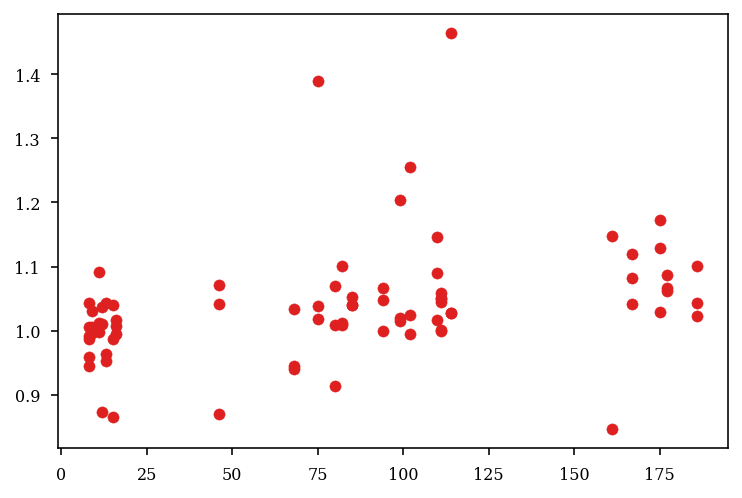

In [195]:
plt.scatter(results.n_target_cells, results.mse_prediction_gain)


Text(0.5, 0, 'n deep / n sup')

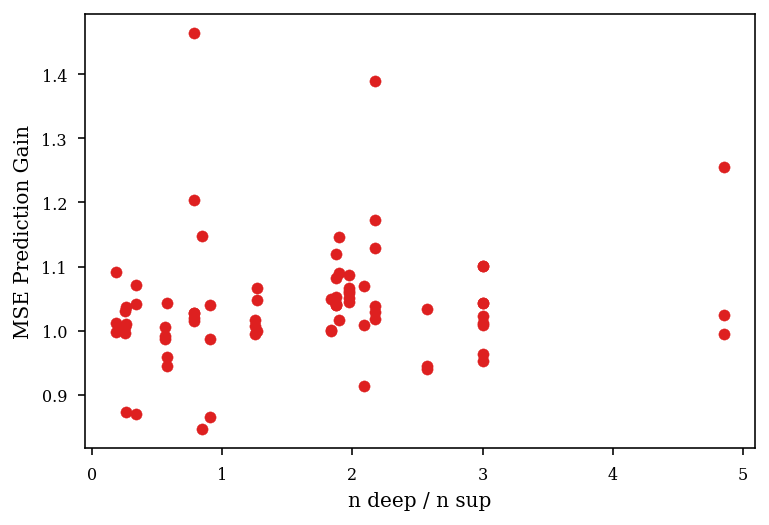

In [196]:
plt.scatter(results.n_deep / results.n_sup, results.mse_prediction_gain)
plt.ylabel("MSE Prediction Gain")
plt.xlabel("n deep / n sup")

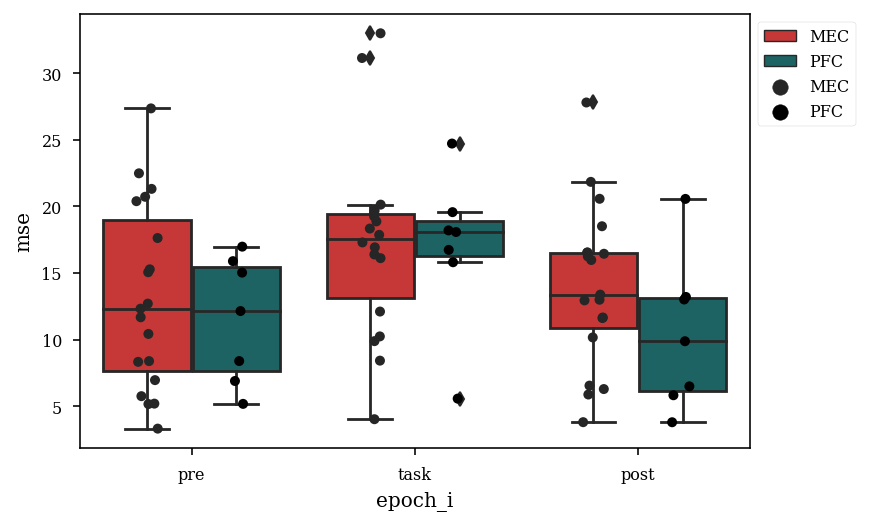

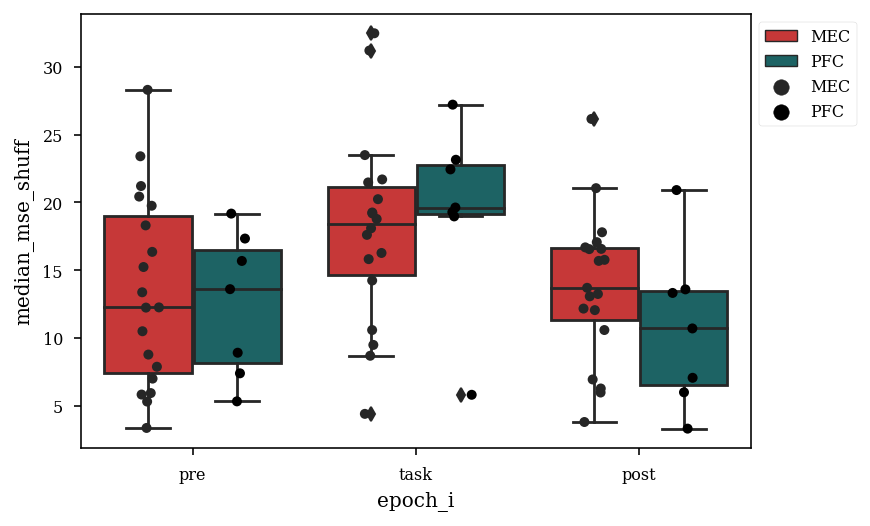

In [197]:
plt.figure()
sns.boxplot(y="mse", x="epoch_i", hue="targ_reg", data=results)
sns.stripplot(y="mse", x="epoch_i", hue="targ_reg", data=results,dodge=True,color="black")
# move legend to the right
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.figure()
sns.boxplot(y="median_mse_shuff", x="epoch_i", hue="targ_reg", data=results)
sns.stripplot(y="median_mse_shuff", x="epoch_i", hue="targ_reg", data=results,dodge=True,color="black")
# move legend to the right
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

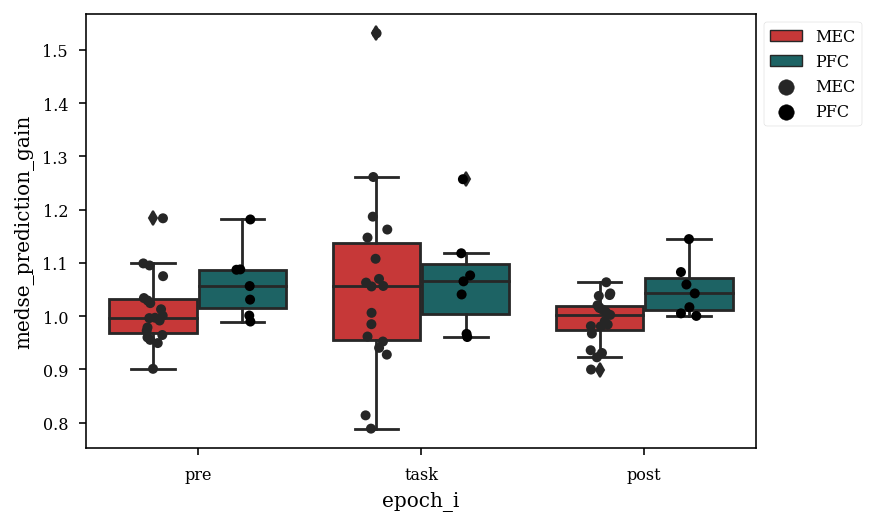

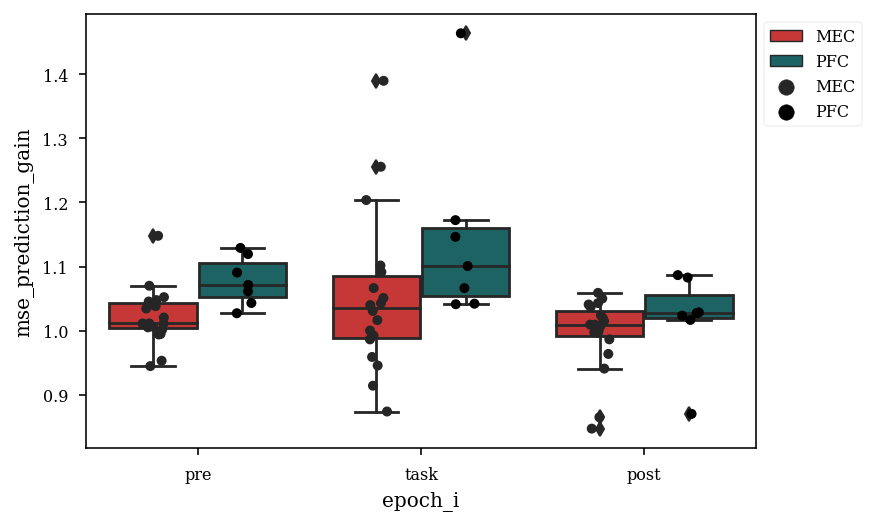

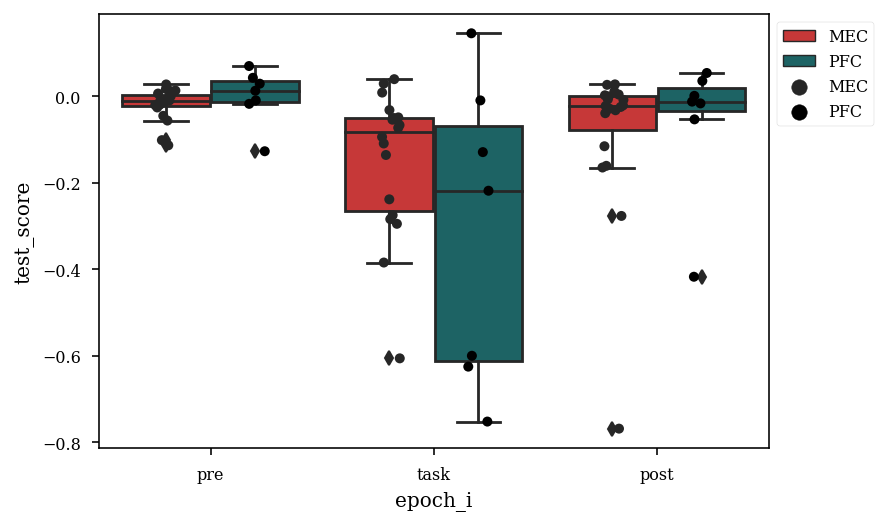

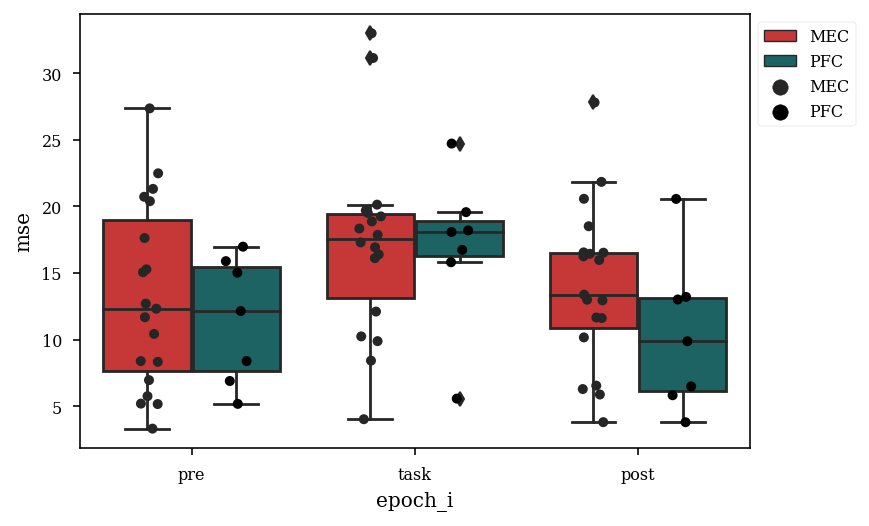

In [198]:
plt.figure()
sns.boxplot(y="medse_prediction_gain", x="epoch_i", hue="targ_reg", data=results)
sns.stripplot(y="medse_prediction_gain", x="epoch_i", hue="targ_reg", data=results,dodge=True,color="black")
# move legend to the right
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.figure()
sns.boxplot(y="mse_prediction_gain", x="epoch_i", hue="targ_reg", data=results)
sns.stripplot(y="mse_prediction_gain", x="epoch_i", hue="targ_reg", data=results,dodge=True,color="black")
# move legend to the right
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.figure()
sns.boxplot(y="test_score", x="epoch_i", hue="targ_reg", data=results)
sns.stripplot(y="test_score", x="epoch_i", hue="targ_reg", data=results,dodge=True,color="black")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.figure()
sns.boxplot(y="mse", x="epoch_i", hue="targ_reg", data=results)
sns.stripplot(y="mse", x="epoch_i", hue="targ_reg", data=results,dodge=True,color="black")
# move legend to the right
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

Text(0.5, 0, '')

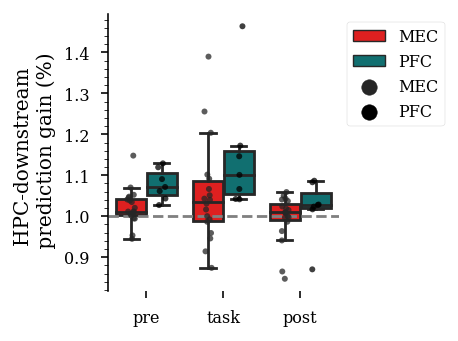

In [199]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=.35, subplots=(2, 1)), edgecolor=None
)

group_colors = {"MEC": "#de2020", "PFC": "#116f70"}
sns.set_palette(sns.color_palette(group_colors.values()))


ax = sns.boxplot(
    y="mse_prediction_gain",
    x="epoch_i",
    hue="targ_reg",
    hue_order=group_colors.keys(),
    data=results,
    showfliers=False,
    saturation=1,
)
sns.stripplot(
    y="mse_prediction_gain",
    x="epoch_i",
    hue="targ_reg",
    data=results,
    dodge=True,
    color="k",
    size=3,
    alpha=0.75,
)

# # move legend to the right
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("HPC-downstream \n prediction gain (%)")
plt.axhline(1, color="grey", linestyle="--")


# box_pairs = [
#     (("pre", "MEC"), ("pre", "PFC")),
#     (("task", "MEC"), ("task", "PFC")),
#     (("post", "MEC"), ("post", "PFC")),
# ]
# add_stat_annotation(
#     plt.gca(),
#     data=results,
#     y="mse_prediction_gain",
#     x="epoch_i",
#     hue="targ_reg",
#     box_pairs=box_pairs,
#     test="Mann-Whitney-ls",
#     text_format="simple",
#     loc="outside",
#     verbose=2,
#     fontsize=8
# )

plt.xlabel("")
# plt.savefig(
#     os.path.join(fig_save_path, "deep_sup_ratio_predict.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

In [200]:
results["constant"] = 1

Text(0.5, 0, '')

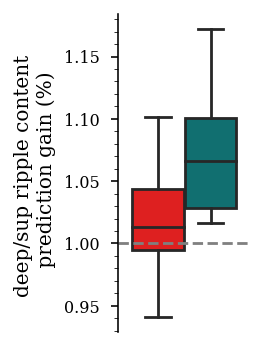

In [201]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=.2, subplots=(4, 1)), edgecolor=None
)

group_colors = {"MEC": "#de2020", "PFC": "#116f70"}
sns.set_palette(sns.color_palette(group_colors.values()))


ax = sns.boxplot(
    y="mse_prediction_gain",
    x="constant",
    hue="targ_reg",
    hue_order=group_colors.keys(),
    data=results,
    showfliers=False,
    saturation=1,
)
# sns.stripplot(
#     y="mse_prediction_gain",
#     x="constant",
#     hue="targ_reg",
#     data=results,
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.75,
# )

# # move legend to the right
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.gca().get_legend().remove()
plt.gca().axes.get_xaxis().set_ticks([])

sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("deep/sup ripple content \n prediction gain (%)")
plt.axhline(1, color="grey", linestyle="--")


plt.xlabel("")
# plt.savefig(
#     os.path.join(fig_save_path, "deep_sup_ratio_predict.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

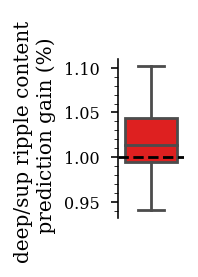

In [116]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=.1, subplots=(4, 1)), edgecolor=None
)

group_colors = {"MEC": "#de2020", "PFC": "#116f70"}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = sns.boxplot(
    y="mse_prediction_gain",
    x="constant",
    data=results.query("targ_reg == 'MEC'"),
    showfliers=False,
    saturation=1,
    color=group_colors["MEC"],
)

plt.gca().axes.get_xaxis().set_ticks([])

sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("deep/sup ripple content \n prediction gain (%)")
plt.axhline(1, color="k", linestyle="--")
plt.xlabel("")
plt.savefig(
    os.path.join(fig_save_path, "deep_sup_ratio_predict_mec.svg"),
    dpi=300,
    bbox_inches="tight",
)

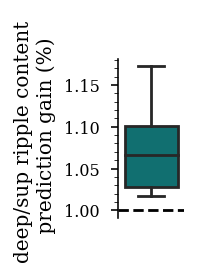

In [115]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=.1, subplots=(4, 1)), edgecolor=None
)

group_colors = {"MEC": "#de2020", "PFC": "#116f70"}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = sns.boxplot(
    y="mse_prediction_gain",
    x="constant",
    data=results.query("targ_reg == 'PFC'"),
    showfliers=False,
    saturation=1,
    color=group_colors["PFC"],
)

plt.gca().axes.get_xaxis().set_ticks([])

sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("deep/sup ripple content \n prediction gain (%)")
plt.axhline(1, color="k", linestyle="--")
plt.xlabel("")
plt.savefig(
    os.path.join(fig_save_path, "deep_sup_ratio_predict_pfc.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [181]:
results

,epoch,epoch_i,targ_reg,n_x_components,mse,medse,median_mse_shuff,median_medse_shuff,mean_score,std_score,test_score,train_score,n_deep,n_sup,n_target_cells,basepath,mse_prediction_gain,medse_prediction_gain,constant
0,sleep,pre,MEC,28,27.052538,36.520284,27.812186,37.689123,NaN,NaN,0.003202,0.045673,19,7,69,Z:\Data\AYAold\AYA7\day24,1.028081,1.032005,1
1,cheeseboard,task,MEC,25,33.454960,35.408897,29.125381,34.229171,NaN,NaN,-0.385609,0.241252,19,7,69,Z:\Data\AYAold\AYA7\day24,0.870585,0.966683,1
2,sleep,post,MEC,29,25.971364,33.830296,26.023712,33.060559,NaN,NaN,-0.061456,0.089853,19,7,69,Z:\Data\AYAold\AYA7\day24,1.002016,0.977247,1
3,sleep,pre,MEC,12,20.907353,32.830727,20.875723,32.805059,NaN,NaN,-0.006102,0.017111,34,7,101,Z:\Data\AYAold\AYA9\day12,0.998487,0.999218,1
4,box,task,MEC,14,15.529245,25.225657,17.951595,27.015293,NaN,NaN,0.074974,0.181682,34,7,101,Z:\Data\AYAold\AYA9\day12,1.155986,1.070945,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,Mwheel,task,MEC,3,10.263235,18.926455,10.404456,18.892379,NaN,NaN,-0.097345,0.015729,8,31,12,Z:\Data\Kenji\ec016.491_508,1.013760,0.998200,1
75,sleep,post,MEC,4,9.709480,21.148714,9.767500,21.051216,NaN,NaN,-0.000869,0.005462,8,31,12,Z:\Data\Kenji\ec016.491_508,1.005976,0.995390,1
76,sleep,pre,MEC,3,3.250608,15.520231,3.241558,15.627824,NaN,NaN,-0.006903,0.003146,8,44,11,Z:\Data\Kenji\ec016.577_590,0.997216,1.006932,1
77,bigSquare,task,MEC,4,4.155509,11.543577,4.304471,12.823178,NaN,NaN,-0.001038,0.032024,8,44,11,Z:\Data\Kenji\ec016.577_590,1.035847,1.110850,1


In [202]:
temp_df = pd.DataFrame()
# results["mse_prediction_gain"] = results["median_mse_shuff"] / results["mse"]
# mse	medse	median_mse_shuff	median_medse_shuff
temp_df["mse"] = np.hstack([results["mse"].values, results["median_mse_shuff"].values])
temp_df["id"] = np.hstack([np.arange(len(results["mse"].values)), np.arange(len(results["mse"].values))])
temp_df["targ_reg"] = np.hstack([results["targ_reg"].values, results["targ_reg"].values])
temp_df["labels"] = np.hstack([["obs"]*len(results["mse"].values), ["shuff"]*len(results["median_mse_shuff"].values)])
temp_df["above_shuff"] = np.hstack([results.mse_prediction_gain > 1,results.mse_prediction_gain > 1])
temp_df["mse_prediction_gain"] = np.hstack([results.mse_prediction_gain,results.mse_prediction_gain])
temp_df["n_x_components"] = np.hstack([results.n_x_components,results.n_x_components])
temp_df["n_deep"] = np.hstack([results.n_deep,results.n_deep])
temp_df["n_sup"] = np.hstack([results.n_sup,results.n_sup])

temp_df["rev_mse"] = 1/temp_df["mse"]
temp_df

,mse,id,targ_reg,labels,above_shuff,mse_prediction_gain,n_x_components,n_deep,n_sup,rev_mse
0,27.356743,0,MEC,obs,True,1.034569,45,18,7,0.036554
1,32.994118,1,MEC,obs,False,0.945694,38,18,7,0.030308
2,27.800415,2,MEC,obs,False,0.940875,43,18,7,0.035971
3,21.316610,3,MEC,obs,False,0.994798,49,34,7,0.046912
4,16.115626,4,MEC,obs,True,1.255670,36,34,7,0.062052
...,...,...,...,...,...,...,...,...,...,...
149,10.581932,72,MEC,shuff,False,0.873931,6,8,31,0.094501
150,12.051275,73,MEC,shuff,True,1.037065,8,8,31,0.082979
151,3.358009,74,MEC,shuff,True,1.011337,7,8,44,0.297795
152,4.396305,75,MEC,shuff,True,1.091471,7,8,44,0.227464


(<AxesSubplot:ylabel='1/mse'>,
 [<statannotations.Annotation.Annotation at 0x20010498f70>])

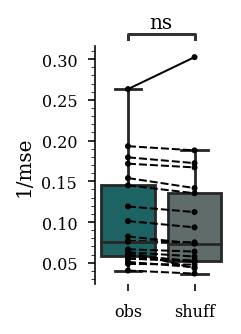

In [203]:
group_colors = {"MEC": "#de2020", "PFC": "#116f70"}

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=.2, subplots=(3, 1)), edgecolor=None
)
sns.boxplot(y="rev_mse", x="labels", data=temp_df.query("targ_reg == 'PFC'"), showfliers=False,palette=sns.color_palette([group_colors["PFC"],"#5e6d6e"]))
sns.stripplot(y="rev_mse", x="labels", data=temp_df.query("targ_reg == 'PFC'"),color="k",jitter=False,size=3)
sns.lineplot(y="rev_mse", x="labels", data=temp_df.query("targ_reg == 'PFC'"), units="id",estimator=None,style="above_shuff",color="k",legend=False,linewidth=1)
sns.despine(bottom=True)
plt.ylabel("1/mse")
plt.xlabel("")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

box_pairs = [("obs", "shuff")]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=temp_df.query("targ_reg == 'PFC'"),
    x="labels",
    y="rev_mse",
)
annotator.configure(
    test="t-test_paired",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()


(<AxesSubplot:xlabel='labels', ylabel='1/mse'>,
 [<statannotations.Annotation.Annotation at 0x2001368a1f0>])

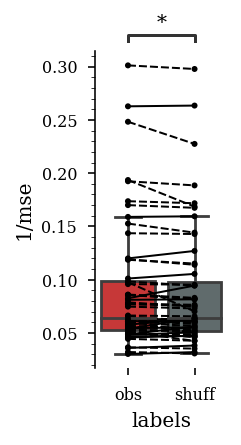

In [204]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(4, 1)), edgecolor=None
)
sns.boxplot(
    y="rev_mse",
    x="labels",
    data=temp_df.query("targ_reg == 'MEC'"),
    showfliers=False,
    palette=sns.color_palette([group_colors["MEC"], "#5e6d6e"]),
)
sns.stripplot(
    y="rev_mse",
    x="labels",
    data=temp_df.query("targ_reg == 'MEC'"),
    color="k",
    jitter=False,
    size=3
)
sns.lineplot(
    y="rev_mse",
    x="labels",
    data=temp_df.query("targ_reg == 'MEC'"),
    units="id",
    estimator=None,
    style="above_shuff",
    color="k",
    legend=False,
    linewidth=1,
)
#     hue="above_shuff",
# palette=sns.color_palette([group_colors["MEC"], "#5e6d6e"])
sns.despine(bottom=True)
plt.ylabel("1/mse")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

box_pairs = [("obs", "shuff")]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=temp_df.query("targ_reg == 'MEC'"),
    x="labels",
    y="rev_mse",
)
annotator.configure(
    test="t-test_paired",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()



<AxesSubplot:xlabel='epoch_i', ylabel='medse'>

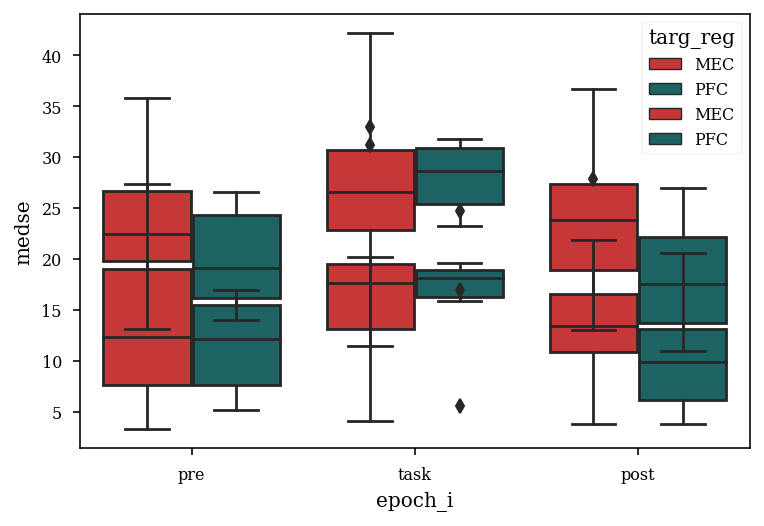

In [205]:
sns.boxplot(y="mse", x="epoch_i", hue="targ_reg", data=results)
sns.boxplot(y="medse", x="epoch_i", hue="targ_reg", data=results)


In [24]:
print(stats.ttest_1samp(results[results.targ_reg == "MEC"].mse_prediction_gain, popmean=1))
print(stats.ttest_1samp(results[results.targ_reg == "PFC"].mse_prediction_gain, popmean=1))

Ttest_1sampResult(statistic=2.0708302870063275, pvalue=0.04308060045548381)
Ttest_1sampResult(statistic=3.4900956906484946, pvalue=0.002307422999898824)


In [71]:
x1 = results[results.targ_reg == "MEC"].mse_prediction_gain.values
x2 = results[results.targ_reg == "PFC"].mse_prediction_gain.values
stats.ttest_ind(x1, x2, equal_var=False)

Ttest_indResult(statistic=-2.2450445805288464, pvalue=0.032347163999970535)

In [ ]:
results = pd.concat([results,pd.get_dummies(results[["targ_reg","epoch_i"]], drop_first=False)],axis=1) 
results

In [70]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
X = pd.get_dummies(results[["targ_reg"]], drop_first=False)
y = results.mse_prediction_gain.values
res2 = sm.OLS(y, X).fit()
print(res2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     6.266
Date:                Fri, 17 Jun 2022   Prob (F-statistic):             0.0145
Time:                        13:47:13   Log-Likelihood:                 76.431
No. Observations:                  77   AIC:                            -148.9
Df Residuals:                      75   BIC:                            -144.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
targ_reg_MEC     1.0233      0.012     84.277   

In [37]:
m1 = smf.ols("mse_prediction_gain ~ targ_reg", data=results).fit()
print(m1.summary())


                             OLS Regression Results                            
Dep. Variable:     mse_prediction_gain   R-squared:                       0.077
Model:                             OLS   Adj. R-squared:                  0.065
Method:                  Least Squares   F-statistic:                     6.266
Date:                 Fri, 17 Jun 2022   Prob (F-statistic):             0.0145
Time:                         12:56:19   Log-Likelihood:                 76.431
No. Observations:                   77   AIC:                            -148.9
Df Residuals:                       75   BIC:                            -144.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0233      

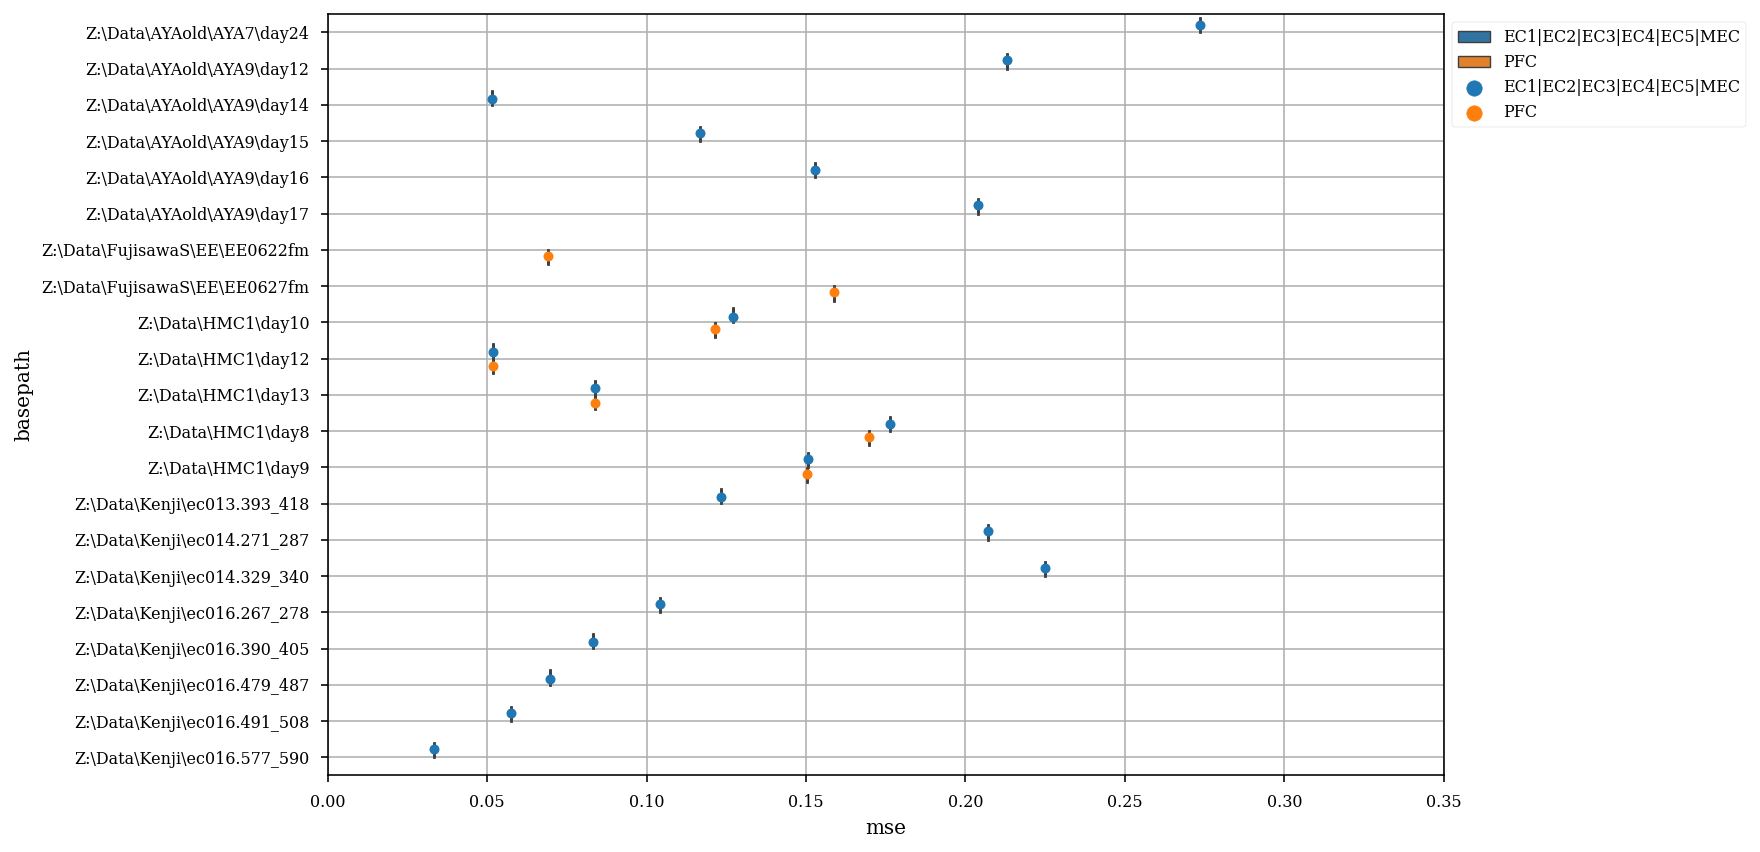

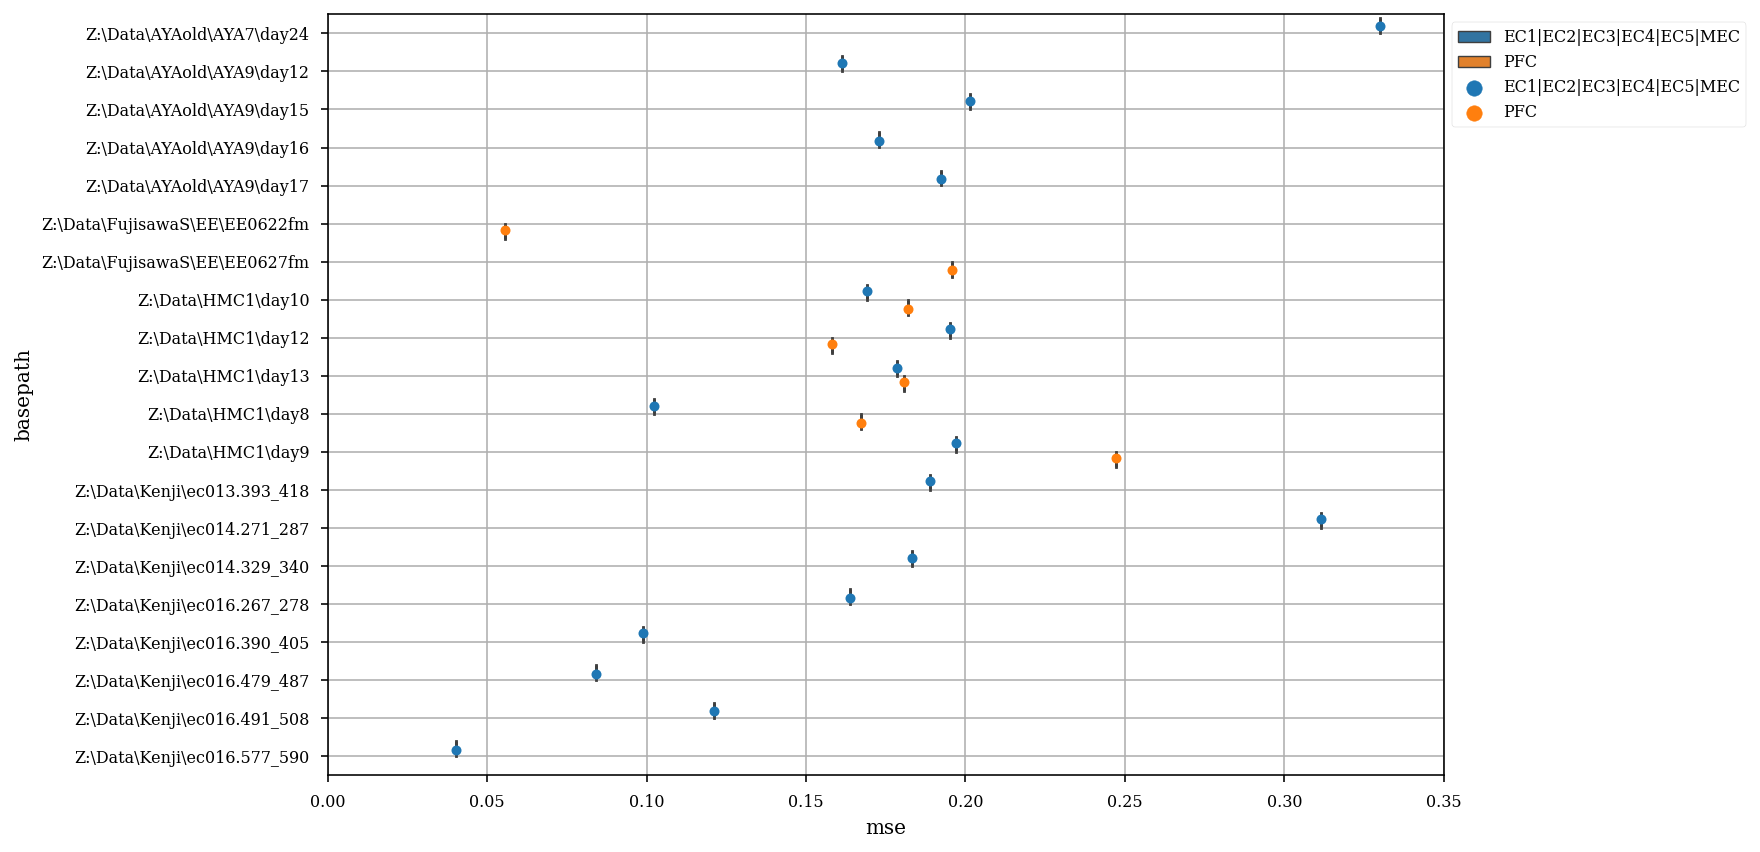

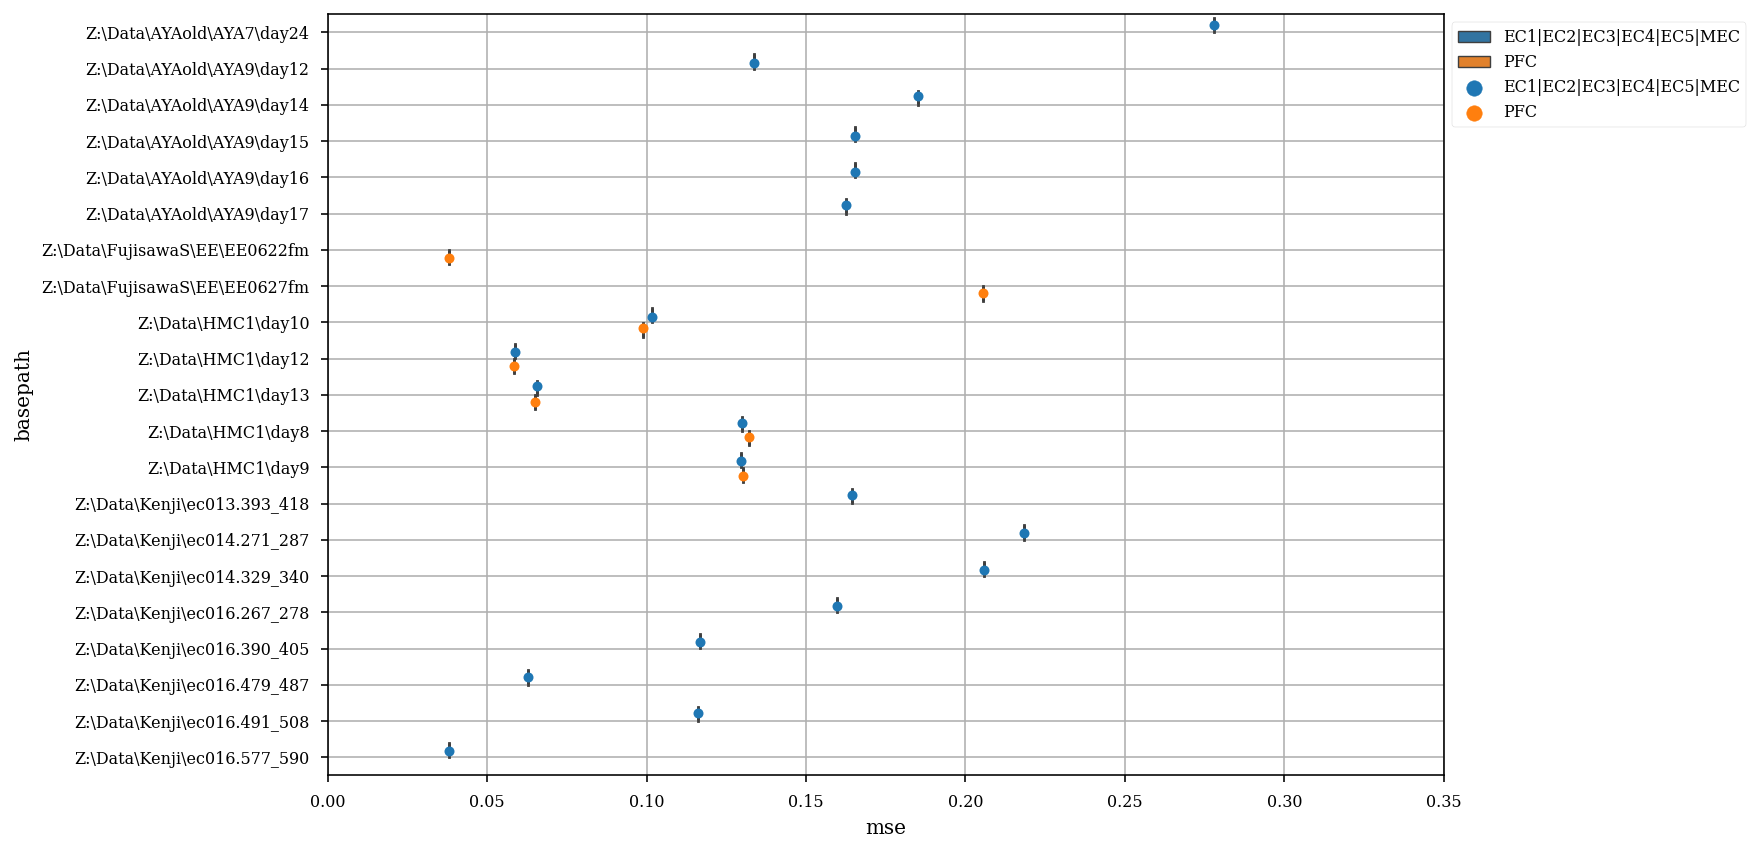

In [55]:
plt.figure(figsize=(10, 7))
sns.boxplot(y="basepath", x="mse", hue="targ_reg", data=results[results.epoch_i==0])
sns.stripplot(y="basepath", x="mse", hue="targ_reg", data=results[results.epoch_i==0], size=5,dodge=True)
plt.grid()
plt.xlim(0, 0.35)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.figure(figsize=(10, 7))
sns.boxplot(y="basepath", x="mse", hue="targ_reg", data=results[results.epoch_i==1])
sns.stripplot(y="basepath", x="mse", hue="targ_reg", data=results[results.epoch_i==1], size=5,dodge=True)
plt.grid()
plt.xlim(0, 0.35)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.figure(figsize=(10, 7))
sns.boxplot(y="basepath", x="mse", hue="targ_reg", data=results[results.epoch_i==2])
sns.stripplot(y="basepath", x="mse", hue="targ_reg", data=results[results.epoch_i==2], size=5,dodge=True)
plt.grid()
plt.xlim(0, 0.35)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))


## Testing below

In [137]:
basepath = r"Z:\Data\HMC1\day8"
# basepath = r"Z:\Data\AYAold\AYA9\day14"

st, cell_metrics = loading.load_spikes(basepath,brainRegion=["CA1","PFC","MEC"])
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)

ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T]).expand(0.1)

ep_df = loading.load_epoch(basepath)
ep_epochs = nel.EpochArray([np.array([ep_df.startTime, ep_df.stopTime]).T])

In [138]:
st = st[ep_epochs[0]]
ripple_epochs = ripple_epochs[ep_epochs[0]]

In [139]:
st_par = functions.get_participation(
    st.data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="binary",
)

In [140]:
ca1_deep_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)
ca1_sup_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Superficial")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)

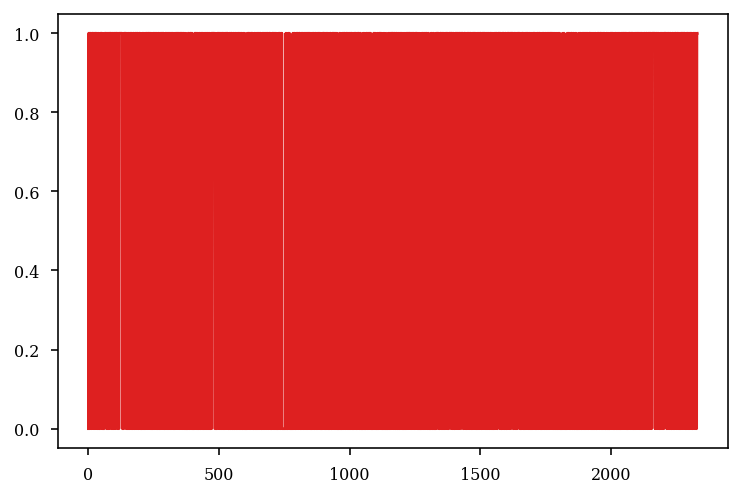

In [144]:
plt.plot(st_par[ca1_deep_idx,:][0,:])

In [187]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

X = st_par[cell_metrics.brainRegion.str.contains("PFC").values, :]
# # get pca dims that explain XX of the variance
X = PCA(n_components=0.80, svd_solver="full").fit_transform(X.T)

y = st_par[ca1_deep_idx,:][4,:]
# bad_idx = np.hstack(np.isinf(y) | np.isnan(y))
# y = y[~bad_idx]
# X = X[~bad_idx, :]

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0
)

clf = RidgeClassifierCV().fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))


0.7676912080057183
0.759914255091104


(0.0, 50.0)

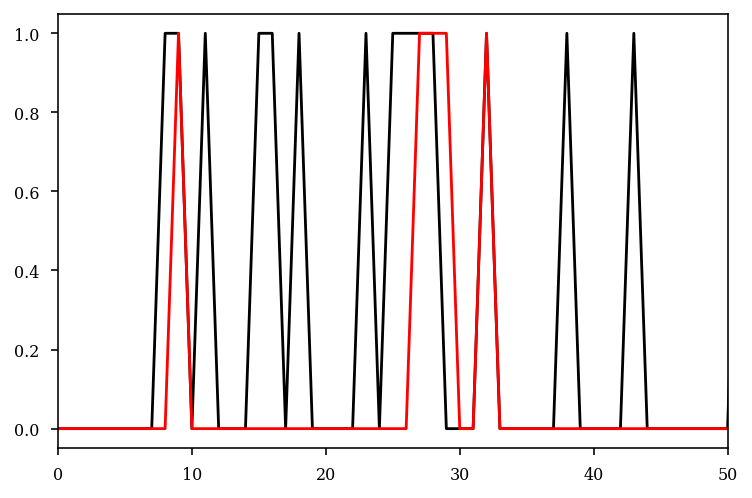

In [190]:
plt.plot(y_test,color="k")

plt.plot(clf.predict(X_test), color="red")
plt.xlim(0,50)

0.7726947819871337
0.7556270096463023


array([0.74089936, 0.76873662, 0.7639485 , 0.74034335, 0.72746781])

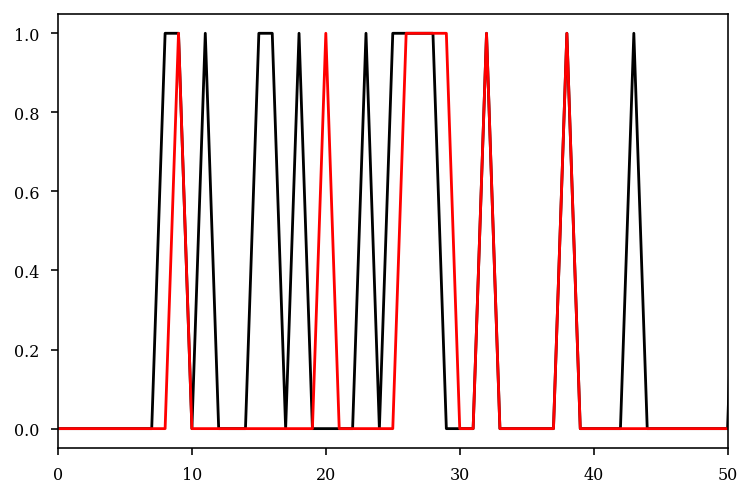

In [193]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

plt.plot(y_test,color="k")

plt.plot(clf.predict(X_test), color="red")
plt.xlim(0,50)

scores = cross_val_score(clf, X, y, cv=5)
scores

In [12]:
target_regions=["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"]  # regions to compare ref to

for region in target_regions:
    print(sum(cell_metrics.brainRegion.str.contains(region).values))
    sum(cell_metrics.brainRegion.str.contains(region).values)

0
161


<AxesSubplot:>

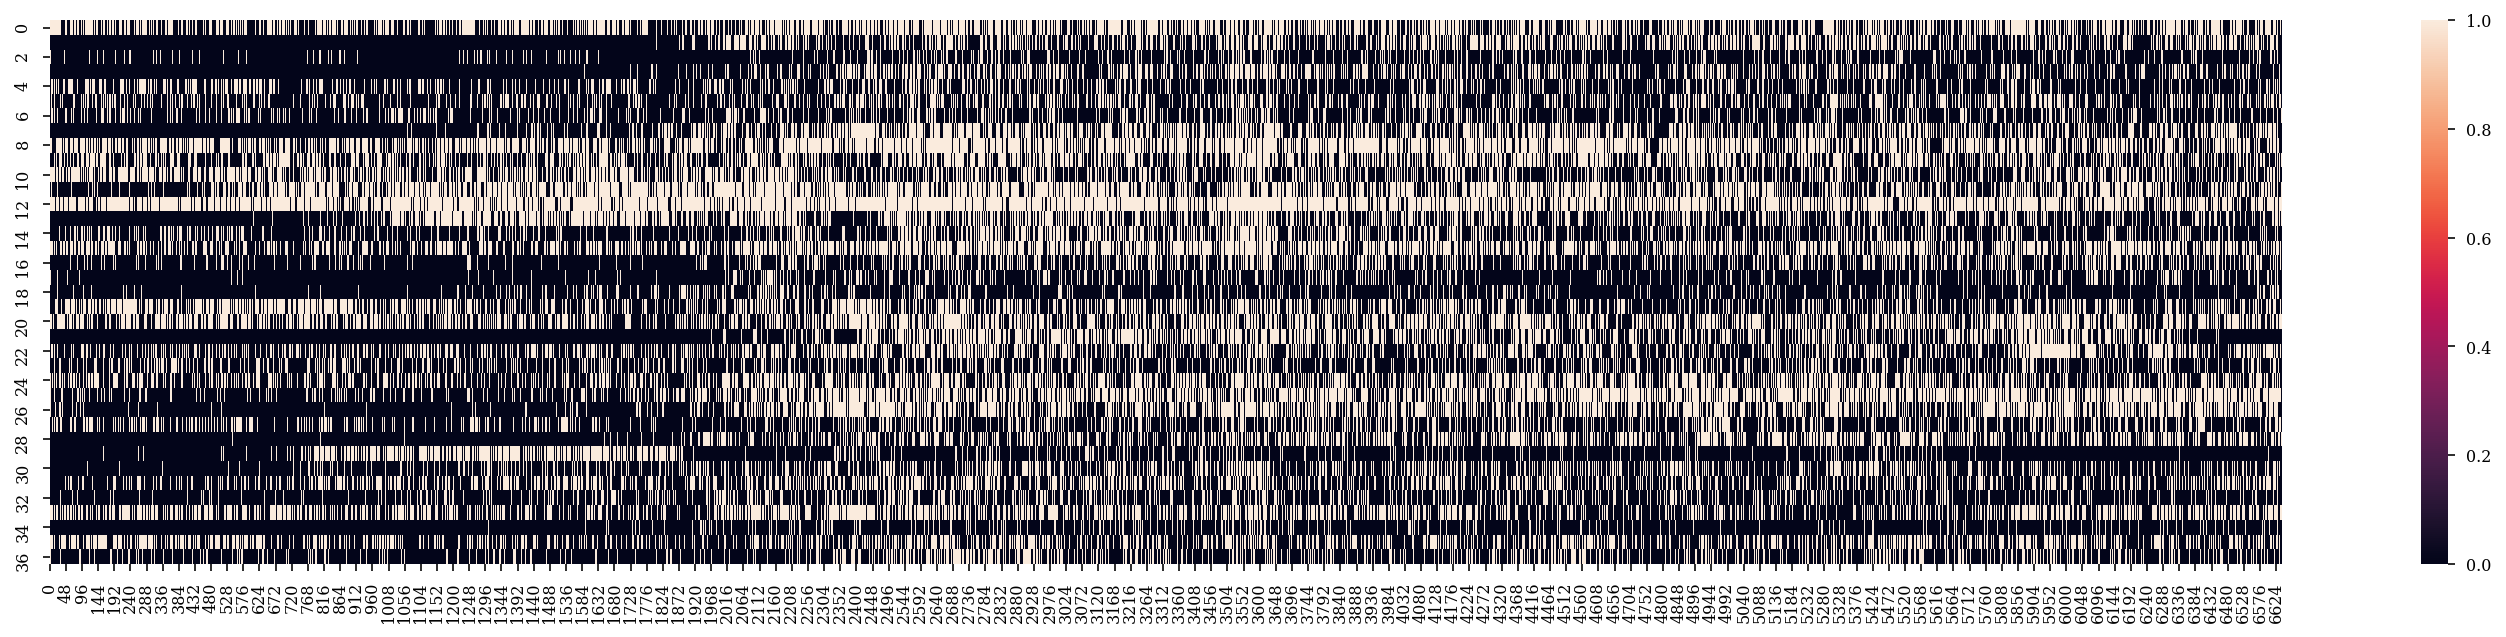

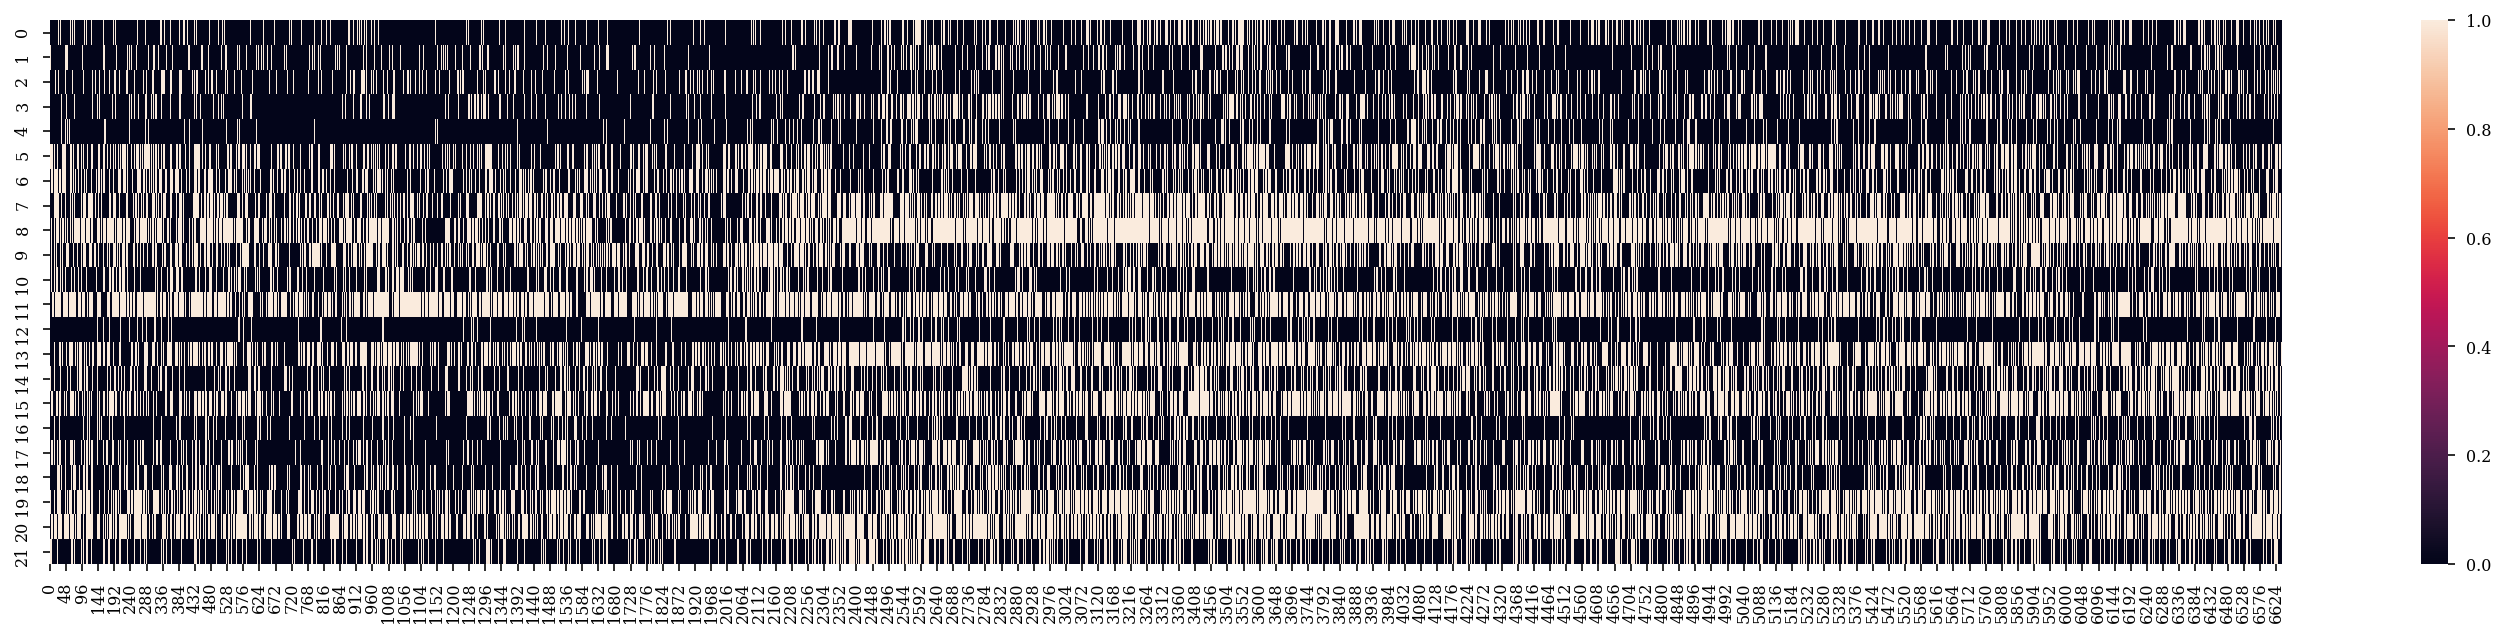

In [228]:
plt.figure(figsize=(25,5))
sns.heatmap(st_par[ca1_deep_idx,:])

plt.figure(figsize=(25,5))
sns.heatmap(st_par[ca1_sup_idx,:])

In [13]:
ca1_deep_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)
ca1_sup_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Superficial")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)

ca1_deep_par = functions.get_participation(
    st.iloc[:, ca1_deep_idx].data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="binary",
)
ca1_sup_par = functions.get_participation(
    st.iloc[:, ca1_sup_idx].data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="binary",
)
deep_sup_ratio = ca1_deep_par.sum(axis=0) / ca1_sup_par.sum(axis=0)
# deep_sup_ratio = ca1_deep_par.mean(axis=0) / ca1_sup_par.mean(axis=0)
# deep_sup_ratio = (ca1_deep_par.sum(axis=0) - ca1_sup_par.sum(axis=0)) / (ca1_deep_par.sum(axis=0) + ca1_sup_par.sum(axis=0))


In [15]:
pfc_deep_idx = cell_metrics.brainRegion.str.contains("PFC").values
mec_sup_idx = cell_metrics.brainRegion.str.contains("MEC").values

pfc_par = functions.get_participation(st.iloc[:,pfc_deep_idx].data,ripple_epochs.starts, ripple_epochs.stops,par_type="binary")
mec_par = functions.get_participation(st.iloc[:,mec_sup_idx].data,ripple_epochs.starts, ripple_epochs.stops,par_type="binary")

In [22]:
pca = PCA(n_components=0.8,svd_solver='full').fit(mec_par.T)
pca.components_.shape, mec_par.shape

((34, 161), (161, 70))

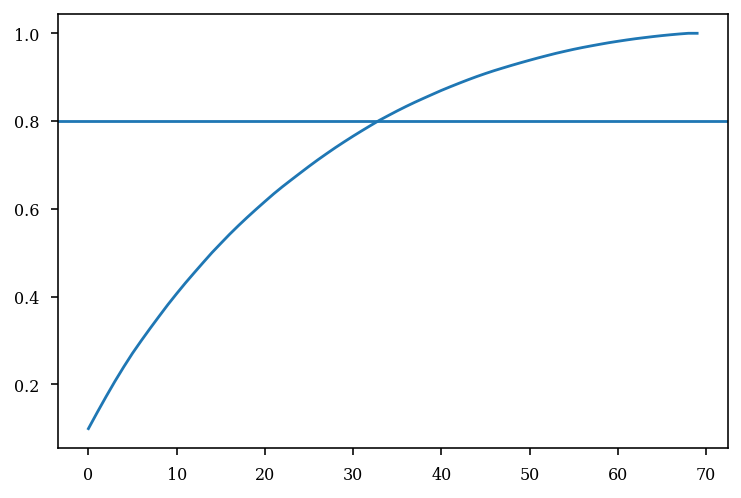

In [17]:
from sklearn.decomposition import PCA
# pfc_par
pca = PCA().fit(mec_par.T)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.axhline(.8)

# n_components = np.where(1-pca.explained_variance_ >= .8)[0][0]

# X_transformed = PCA(n_components=n_components).fit_transform(pfc_par.T)
# plt.figure(figsize=(25,5))
# sns.heatmap(X_transformed.T)

In [50]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=10)
X_transformed = embedding.fit_transform(pfc_par.T)

X_transformed.shape

(2332, 10)

<AxesSubplot:>

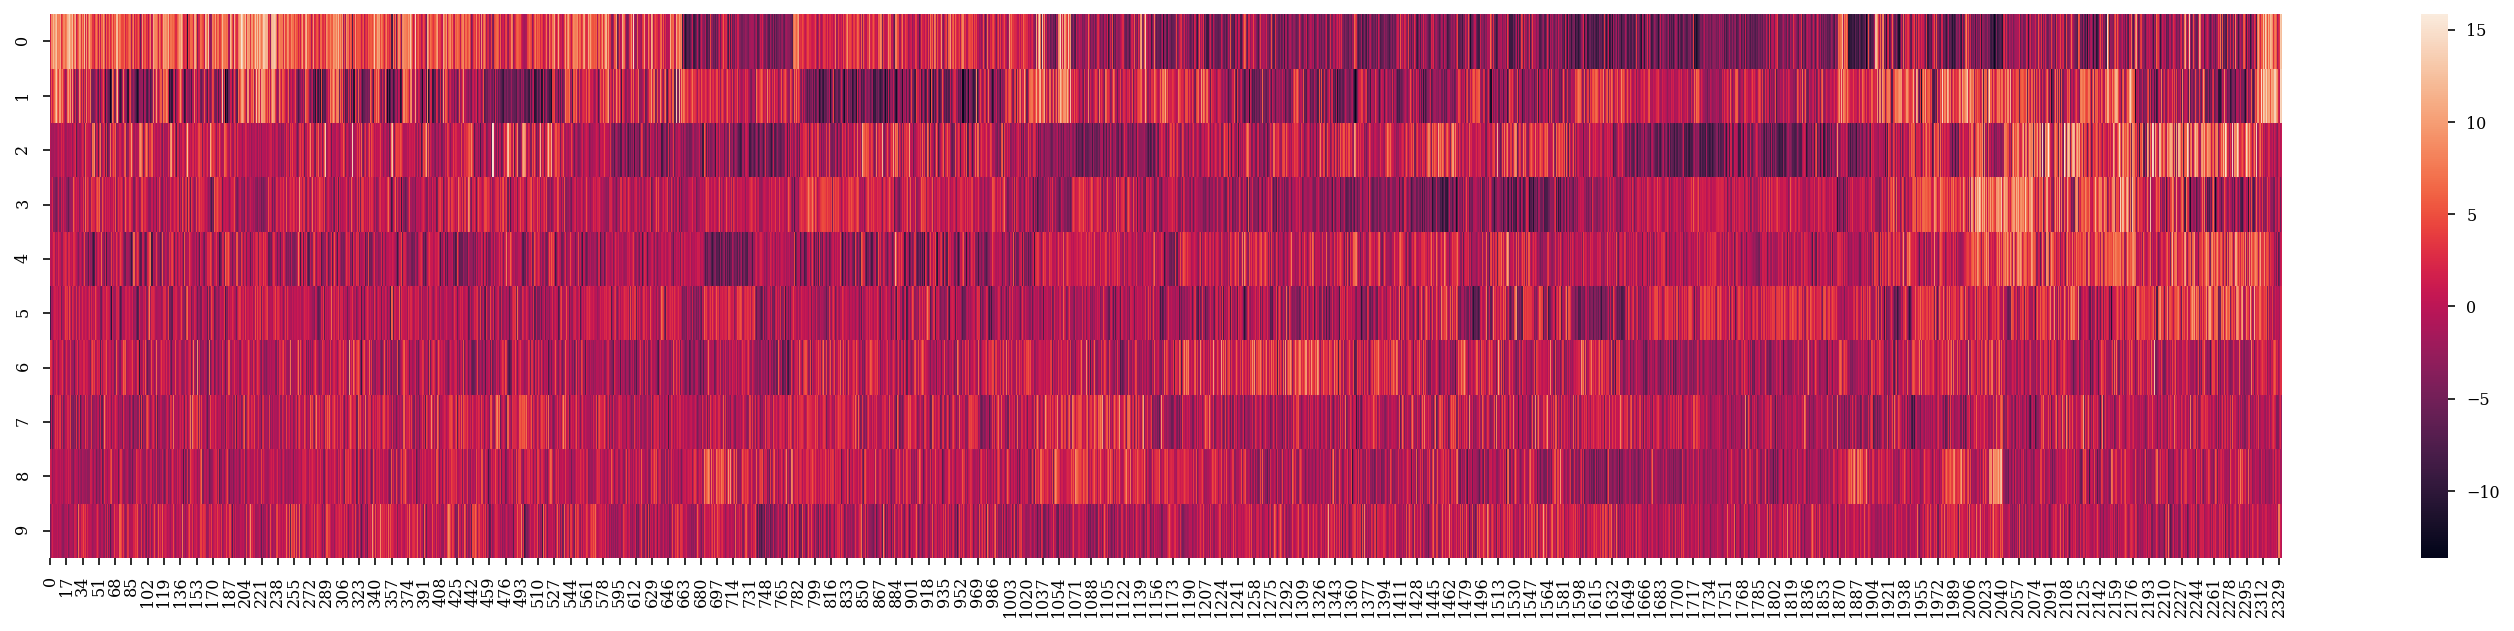

In [51]:
plt.figure(figsize=(25,5))
sns.heatmap(X_transformed.T)

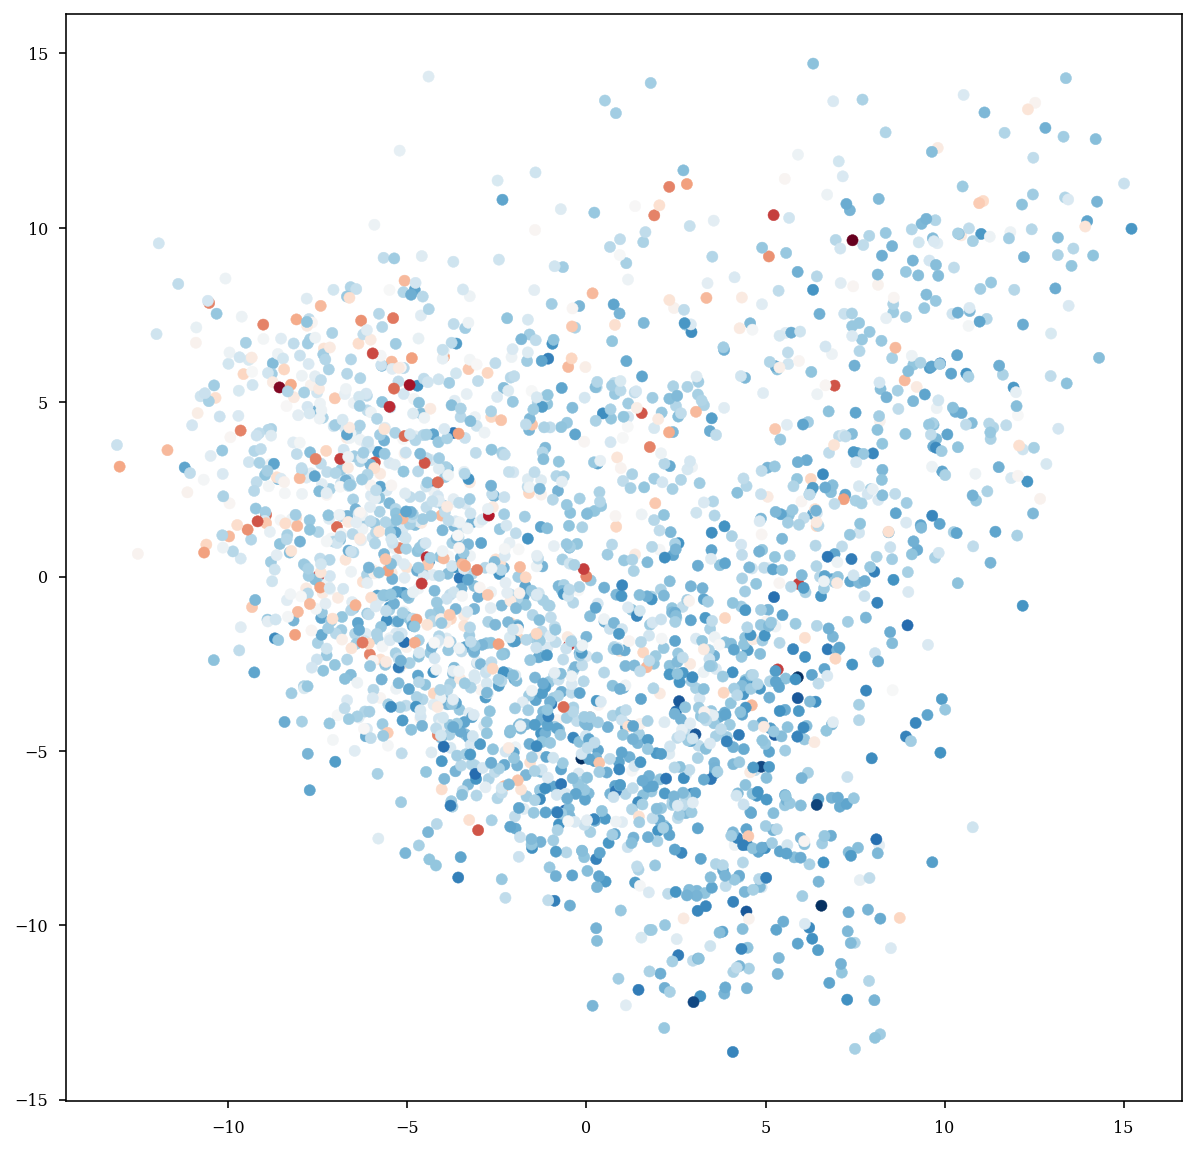

In [256]:
plt.figure(figsize=(10,10))
plt.scatter(X_transformed[:,0],X_transformed[:,1],c=np.log(deep_sup_ratio+1),cmap="RdBu_r")

<AxesSubplot:>

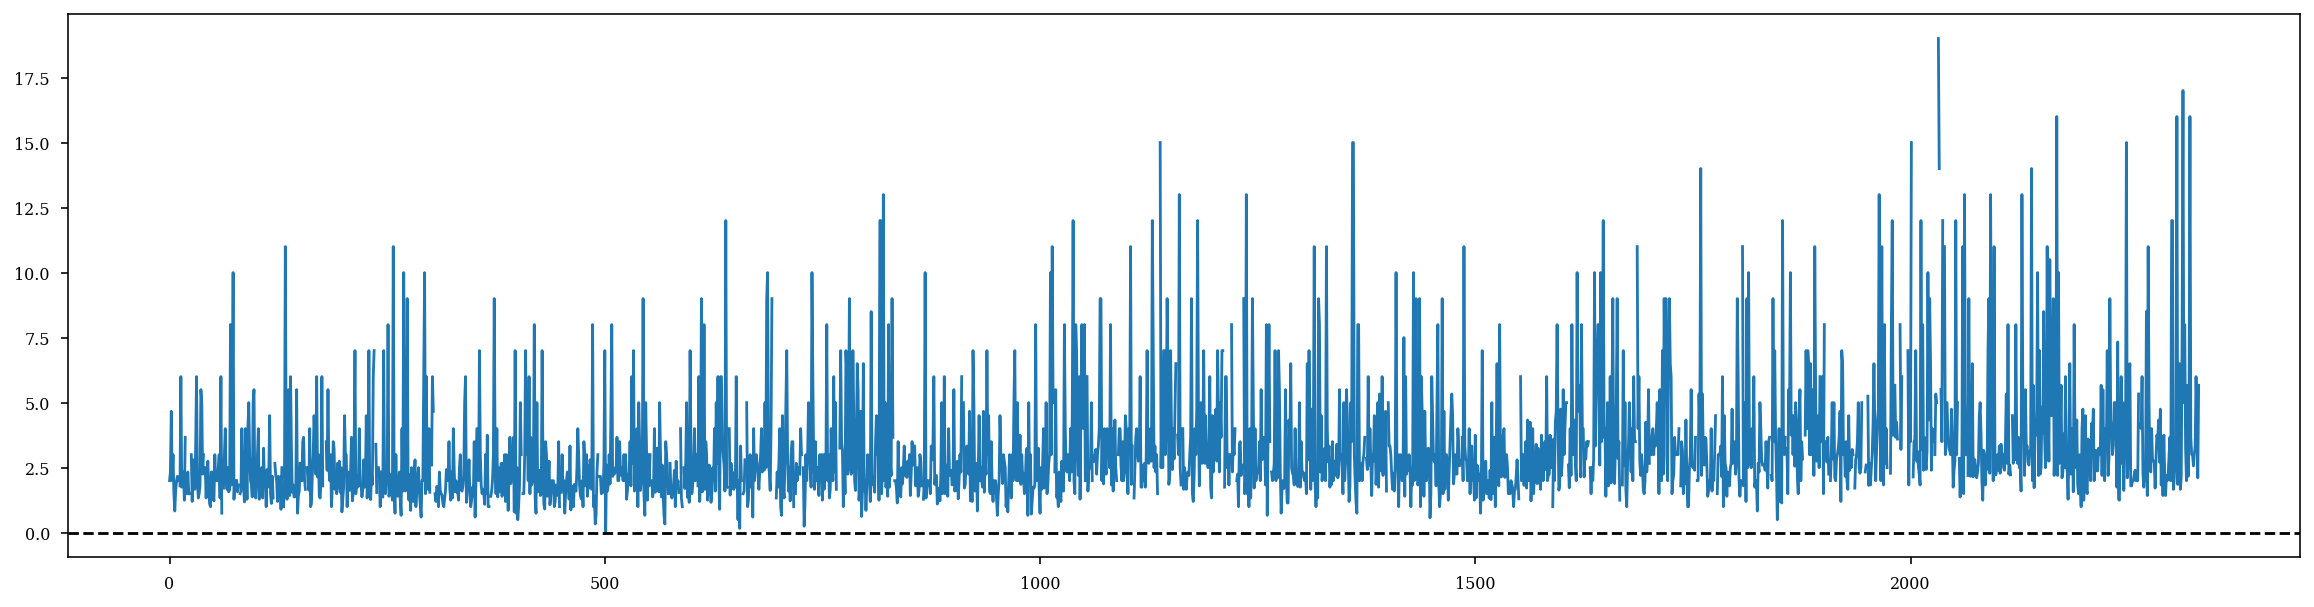

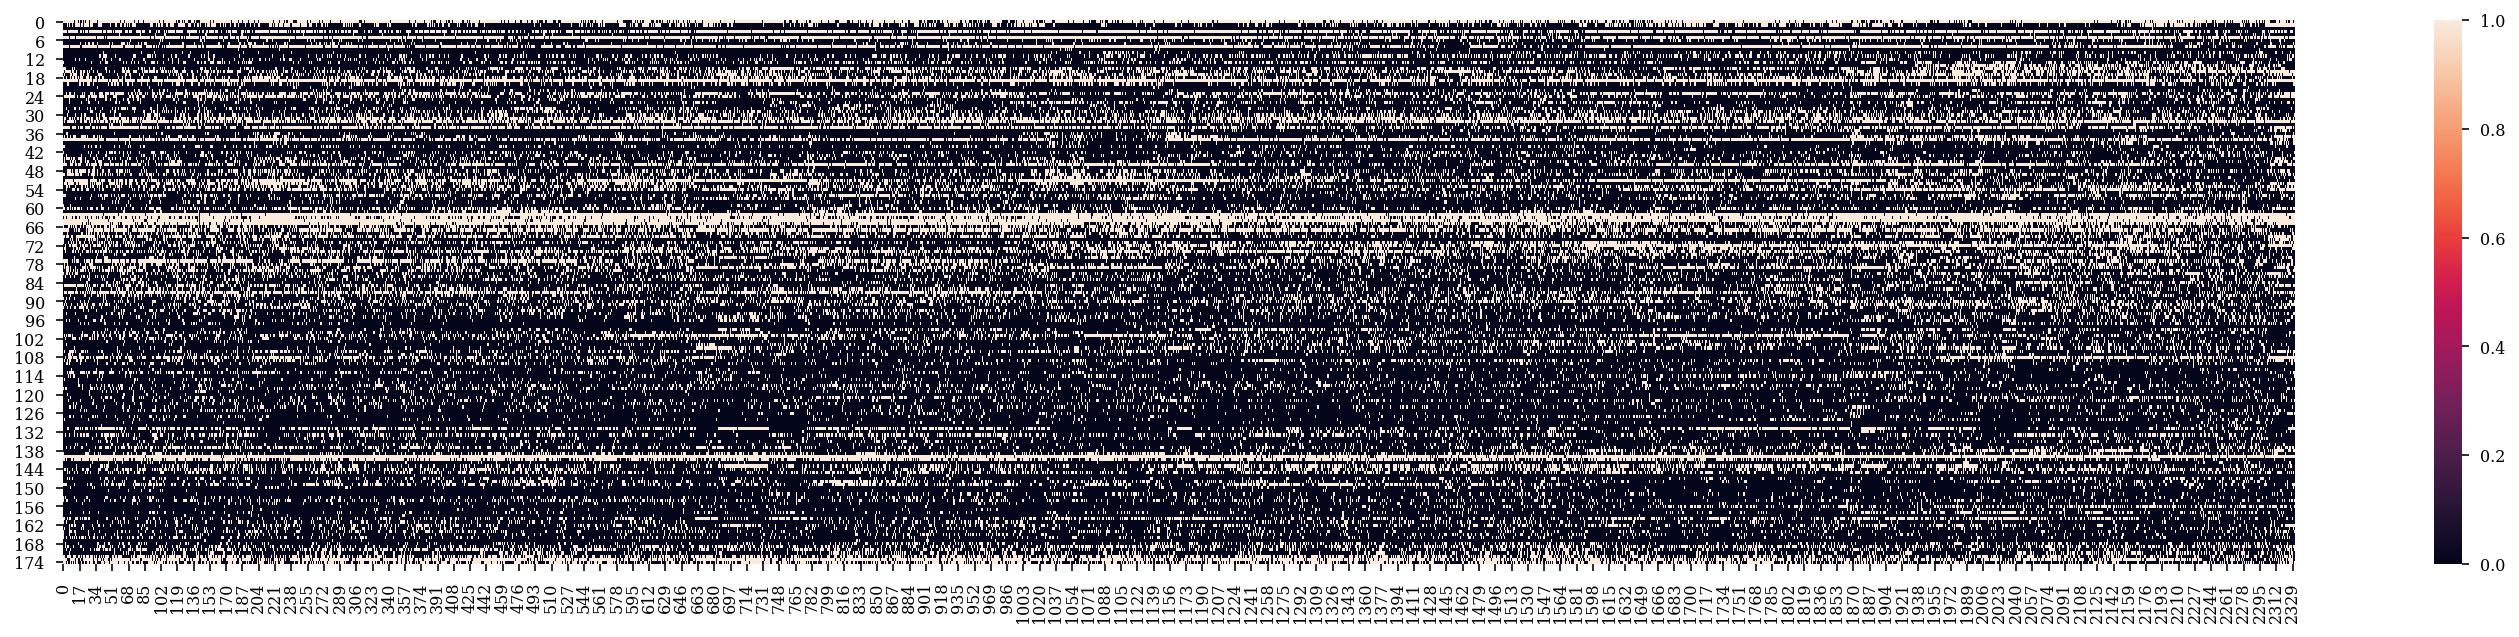

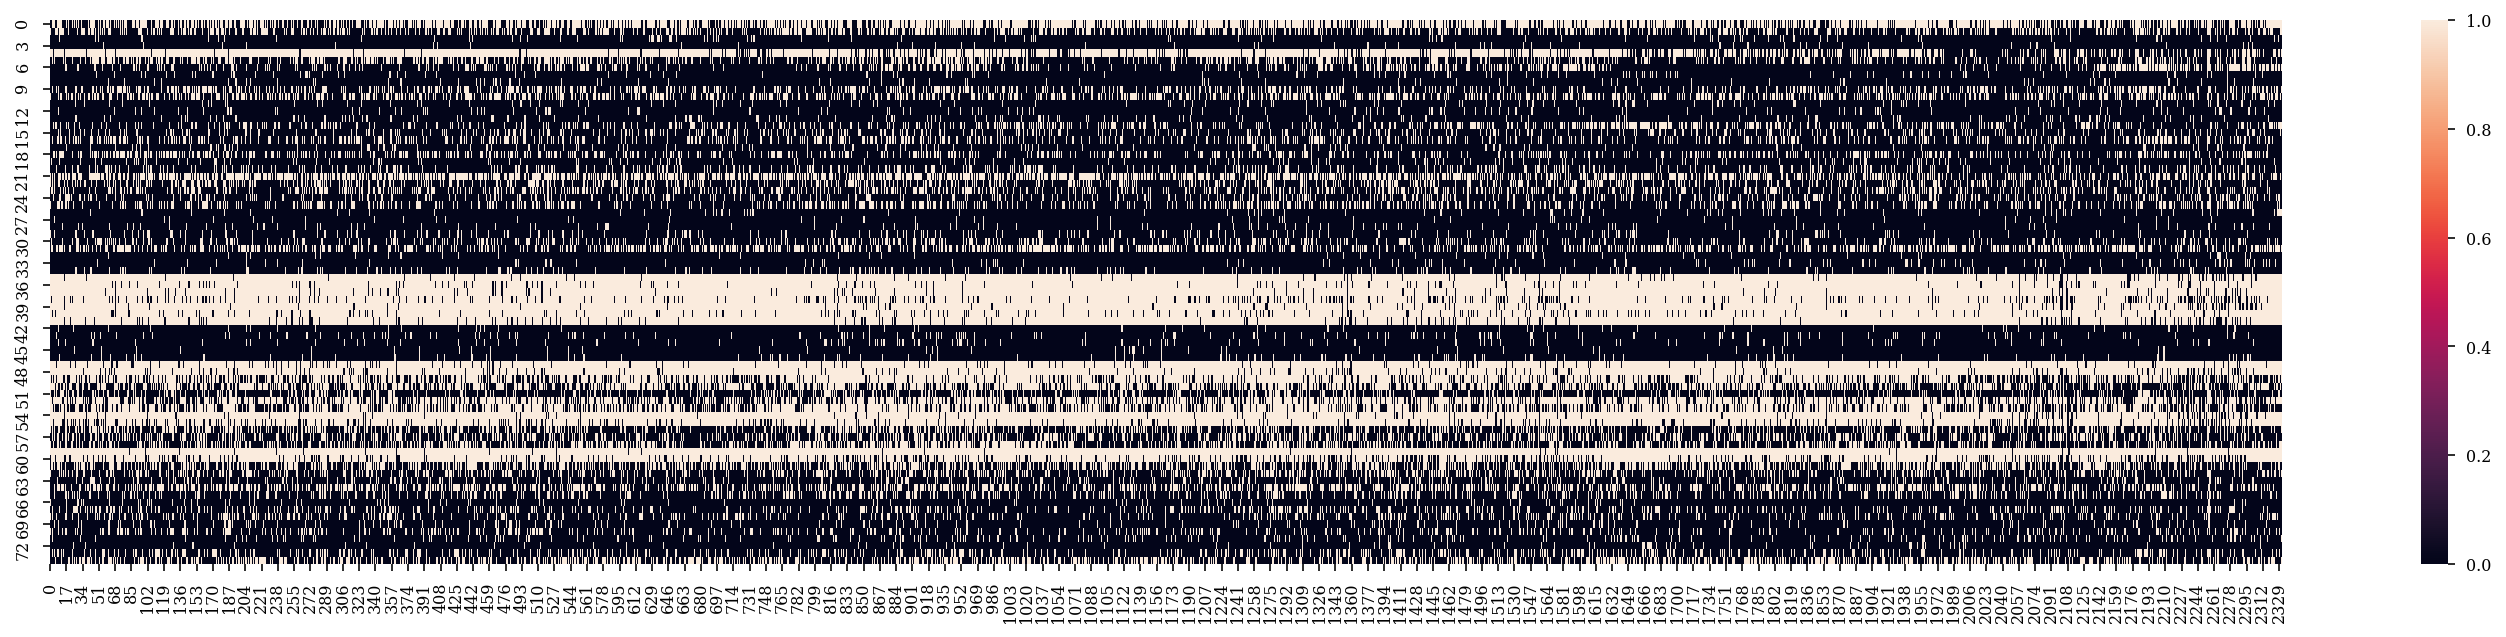

In [24]:
plt.figure(figsize=(20,5))
plt.plot(deep_sup_ratio)
plt.axhline(0,color="k",linestyle="--")
plt.figure(figsize=(25,5))
sns.heatmap(pfc_par)
plt.figure(figsize=(25,5))
sns.heatmap(mec_par)

In [ ]:
df = pd.DataFrame(mec_par.T)
# df["mec_par"] = mec_par
df["target"] = deep_sup_ratio
df

corr = df.corr()['target'][df.corr()['target'] < 1].abs()
# corr.sort(ascending=False)
# corr.head()
idx = np.argsort(-corr)

corr[idx]


In [71]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

# X = pfc_par.T
X = X_transformed
y = np.log(deep_sup_ratio+1).reshape(-1,1)
# y = deep_sup_ratio.reshape(-1,1)

bad_idx = np.isinf(deep_sup_ratio) | np.isnan(deep_sup_ratio)
y = y[~bad_idx]
X = X[~bad_idx]

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


In [72]:
X.shape

(2231, 35)

In [102]:
from sklearn.linear_model import RidgeCV
reg = RidgeCV().fit(X_train, y_train)
print(reg.score(X_test, y_test))
print(reg.score(X_train, y_train))

0.0891360727049143
0.16136582402537747


In [99]:
from sklearn import linear_model
reg = linear_model.BayesianRidge().fit(X_train, y_train)
print(reg.score(X_test, y_test))
print(reg.score(X_train, y_train))
pred = reg.predict(X_test)
print(mean_squared_error(y_test, pred))
scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.09726722732719773
0.15819512011515535
0.16021154051750144
[-0.05670061 -0.0223033   0.01834032  0.03711045 -0.10053609]
-0.02 accuracy with a standard deviation of 0.05


In [91]:
from sklearn.svm import SVR
reg = SVR().fit(X_train, y_train)
print(reg.score(X_test, y_test))
print(reg.score(X_train, y_train))

0.02574597823195368
0.7758616522250146


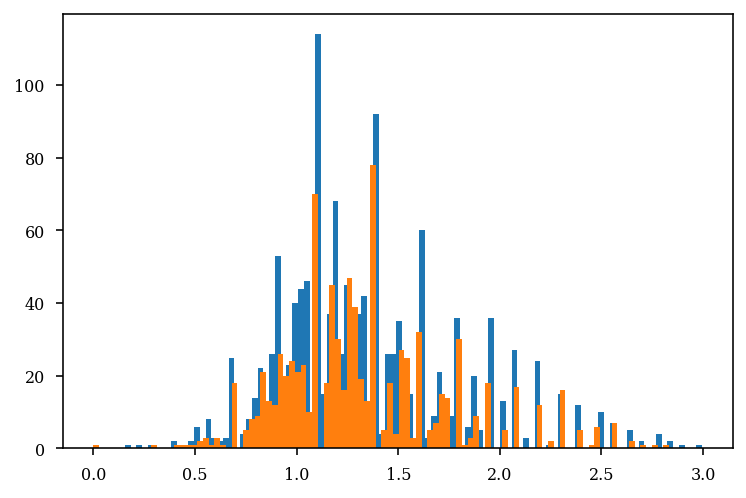

In [89]:
plt.hist(y_train,100)
plt.hist(y_test,100)
plt.show()

In [100]:
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_test, y_test))
print(reg.score(X_train, y_train))

pred = reg.predict(X_test)

mse = mean_squared_error(y_test, pred)
print(mse)

scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.0884801077633075
0.16137496394219086
0.1617710252339742
[-0.03374946 -0.03251741  0.01557499  0.0296914  -0.02521706]
-0.01 accuracy with a standard deviation of 0.03


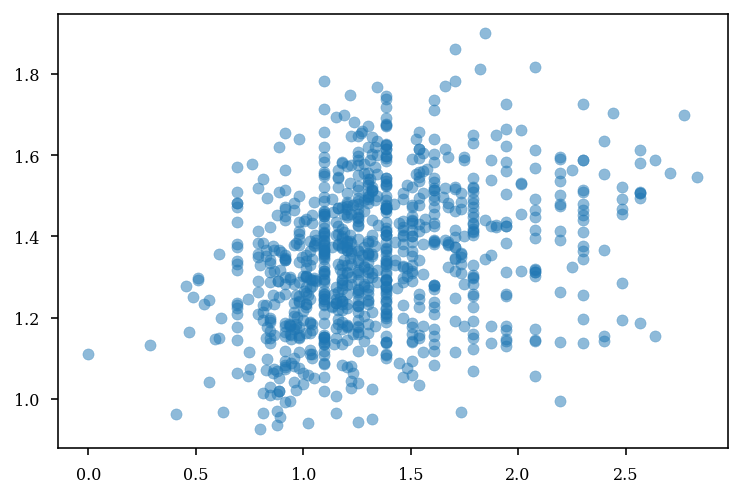

In [30]:
plt.scatter(y_test,pred,alpha=0.5)
# plt.axis("square")
# plt.ylim(0,3)
plt.show()

In [62]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, pred)
mse

4.578292035320783

In [63]:
scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[-0.02761957 -0.06379941  0.00020244  0.02407037 -0.00402143]
-0.01 accuracy with a standard deviation of 0.03


In [83]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE

from sklearn.model_selection import GridSearchCV

# set up our search grid
param_grid = {
    "max_depth": [4, 5],
    "n_estimators": [500, 600, 700],
    "learning_rate": [0.01, 0.015],
}

regressor = xgb.XGBRegressor(seed=123, eval_metric="rmsle")

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ", search.best_params_)


The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}


In [84]:
regressor = xgb.XGBRegressor(
    learning_rate=search.best_params_["learning_rate"],
    n_estimators=search.best_params_["n_estimators"],
    max_depth=search.best_params_["max_depth"],
    eval_metric="rmsle",
)

regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)


In [85]:
print(regressor.score(X_test, y_test))
print(regressor.score(X_train, y_train))

0.06303038866539346
0.5260519674487703


In [67]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions))
print("The score is %.5f" % RMSLE )

mse = mean_squared_error(y_test, predictions)
mse

The score is 0.41912


4.60469053199608

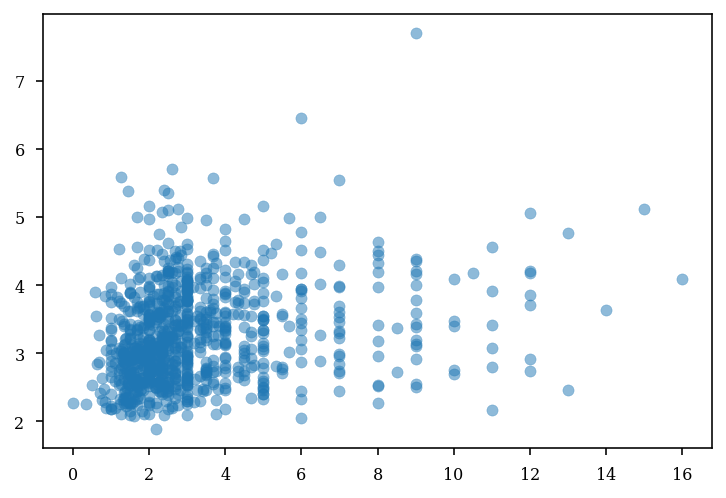

In [68]:
plt.scatter(y_test,predictions,alpha=0.5)
# plt.axis("square")
# plt.xlim(-.5,2.5)
# plt.ylim(-.5,2.5)
plt.show()

In [20]:


model = xgb.XGBRegressor(seed = 123)
# define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
# scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = cross_val_score(model, X, y, cv=5)
# scores = np.abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

model.fit(X_train, y_train)

pred = model.predict(X_test)

Mean MAE: -0.235 (0.088)


In [21]:
score = model.score(X_test, y_test) 
score

-0.13912759088730908

In [22]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, pred)
mse

5.544877058584767

(0.0, 200.0)

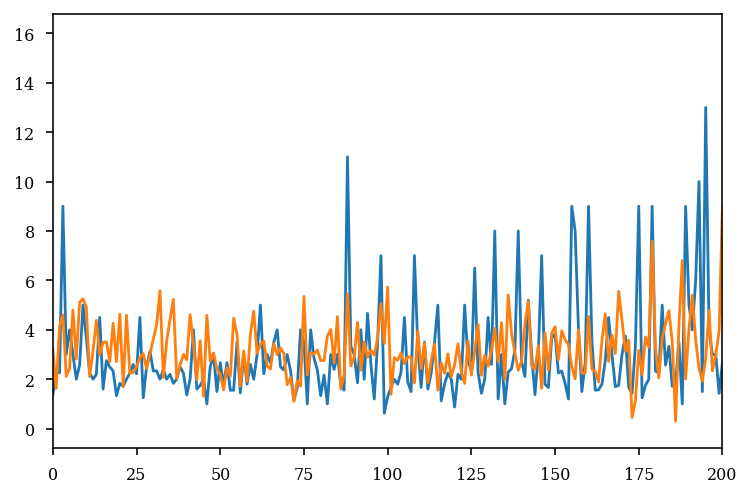

In [23]:
plt.plot(y_test)
plt.plot(pred)
plt.xlim(0,200)

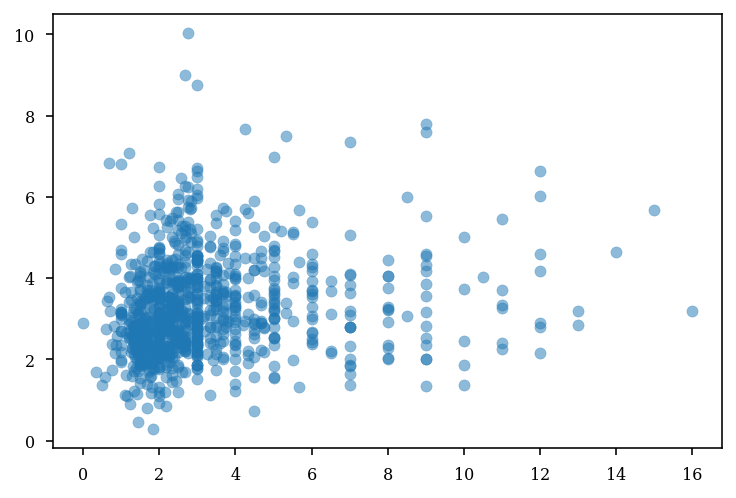

In [24]:
plt.scatter(y_test,pred,alpha=0.5)
# plt.axis("square")
# plt.xlim(-.5,2.5)
# plt.ylim(-.5,2.5)
plt.show()

In [25]:
# Train and test set are converted to DMatrix objects,
# as it is required by learning API.
train_dmatrix = xgb. (data = X_train, label = y_train)
test_dmatrix = xgb.DMatrix(data = X_test, label = y_test)
 
# Parameter dictionary specifying base learner
param = {"booster":"gblinear", "objective":"reg:squarederror"}
 
xgb_r = xgb.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
pred = xgb_r.predict(test_dmatrix)
 
# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  2.237715


In [33]:
# xgb_r.get_score()

In [27]:
mse = mean_squared_error(y_test, pred)
mse

5.007368659984908

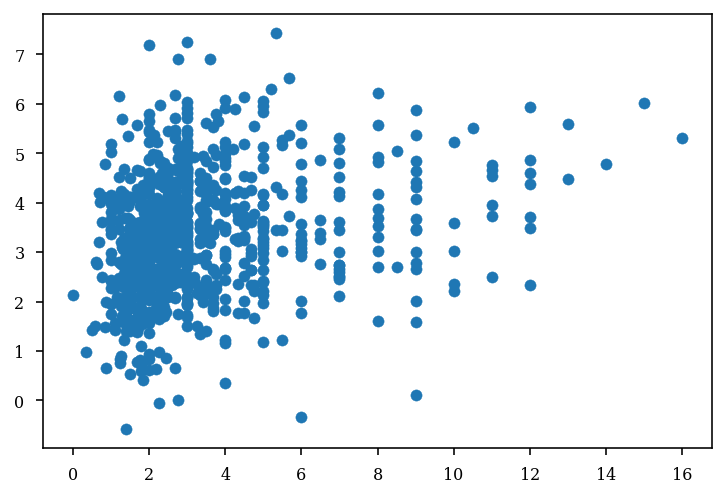

In [26]:
plt.scatter(y_test,pred)
# plt.axis("square")

In [ ]:
reg = Lasso().fit(X_train, y_train)
reg.score(X_test, y_test)

-6.0279201143709216e-05

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(random_state=0)
reg = BaggingRegressor(extra_tree, random_state=0).fit(
    X_train, y_train)
reg.score(X_test, y_test)

-0.20827310041102876

In [ ]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((2614, 23), (2614, 1), (3920, 23), (3920, 1))

In [ ]:


reg = make_pipeline(preprocessing.StandardScaler(), BaggingRegressor(extra_tree, random_state=0))

scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[-0.25122904 -0.19895562 -0.41078681 -0.20635456 -0.16995342]
-0.25 accuracy with a standard deviation of 0.09


In [136]:
from elephant.causality.granger import pairwise_granger
pairwise_granger(np.random.uniform(size=(1000, 2)), max_order=2)


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\causality\granger.py:494: UserWarning: The value of the log determinant is at or below the tolerance level. Proceeding with computation.


Causality(directional_causality_x_y=0.0, directional_causality_y_x=0.01, instantaneous_causality=0.0, total_interdependence=0.01)

In [167]:
x = np.random.randn(1001)
y = 3.5 * x[:-1] + np.random.randn(1000)
signals = np.array([x[1:], y]).T  # N x 2 matrix
pairwise_granger(signals, max_order=1)

Causality(directional_causality_x_y=2.47, directional_causality_y_x=0.0, instantaneous_causality=0.0, total_interdependence=2.47)

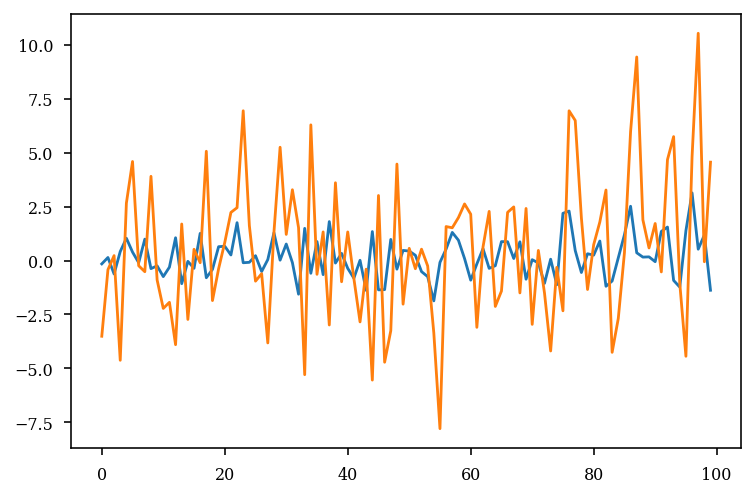

In [174]:
plt.plot(signals[0:100,0])
plt.plot(signals[0:100,1])

In [202]:
directional_causality_x_y = []
for x in X_test.T:
    signals = np.hstack([y_test.reshape(-1,1),x.reshape(-1,1)])
    out = pairwise_granger(signals, max_order=1)
    # signals
    # X_test.shape, y_test.shape
    directional_causality_x_y.append(out.directional_causality_x_y)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\causality\granger.py:494: UserWarning: The value of the log determinant is at or below the tolerance level. Proceeding with computation.


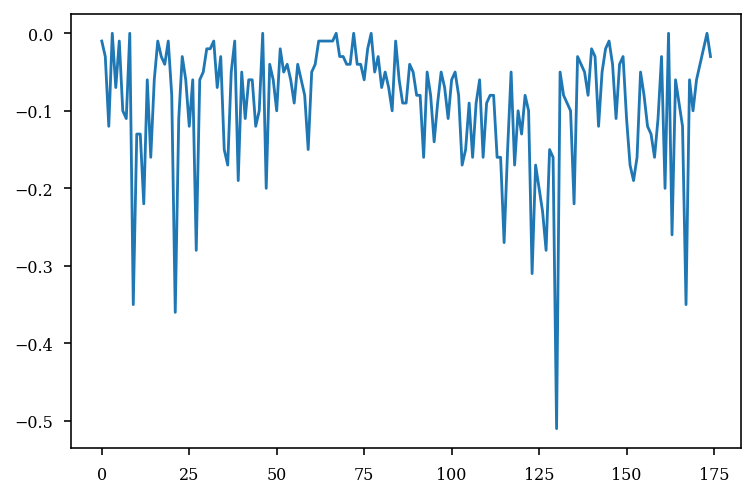

In [204]:
plt.plot(directional_causality_x_y)

(0.0, 100.0)

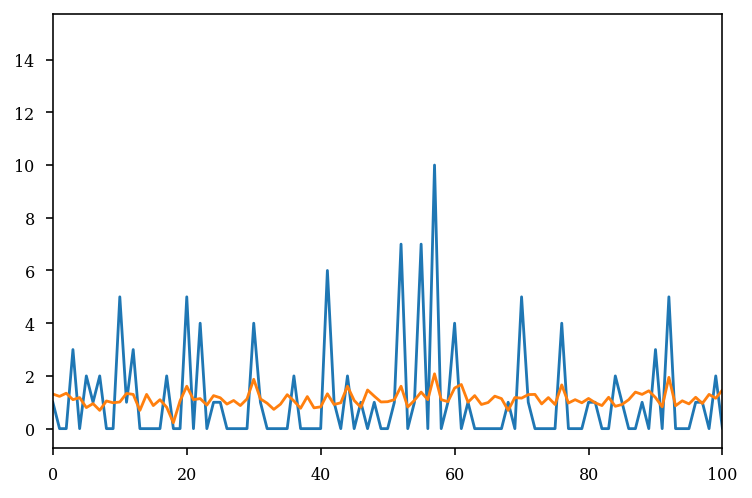

In [215]:
np.argmin(directional_causality_x_y)

    # signals = np.hstack([y_test.reshape(-1,1),.reshape(-1,1)])
plt.plot(X_test[:,np.argmax(directional_causality_x_y)])
plt.plot(y_test)
plt.xlim(0,100)